<a href="https://colab.research.google.com/github/killian31/Multilingual-Machine-Reading/blob/main/Multilingual_machine_reading_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project group NLP

By Rikke Nissen and Killian Steunou

In [ ]:
import torch
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")
print(device)

cuda


# Setting up

In [ ]:
!pip install datasets
!pip install spacy
!python -m spacy download ja_core_news_sm
!python -m spacy download fi_core_news_sm
!pip3 install bpemb
!pip install farm-haystack
!pip3 install transformers
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 14.6 MB/s 
     |████████████████████████████████| 115 kB 53.5 MB/s 
     |████████████████████████████████| 163 kB 46.7 MB/s 
     |████████████████████████████████| 95 kB 1.9 MB/s 
     |████████████████████████████████| 212 kB 64.0 MB/s 
     |████████████████████████████████| 127 kB 3.4 MB/s 
     |████████████████████████████████| 115 kB 16.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 1.2 MB/s 
     |████████████████████████████████| 2.2 MB 14.9 MB/s 
  Created wheel for sudachidict-core: filename=SudachiDict_core-20221021-py3-none-any.whl size=71574782 sha256=a4f8e438fd3b9092092c6601bd53d22f86d090f30f63a46b36b5293308a9f130
  Stored in directory: /root/.cache/pip/wheels/66/a9/e1/bde612c31f0ae6877e7e39f278076befd399c488cba80292b6
Successfully built sudachidict-core
✔ Download and installation successful
You can now load the package via spacy.load('ja_core_news_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.3 MB 1.4 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fi_core_news_sm')
Lookin

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import re
import spacy
import random
import numpy as np
import pandas as pd
import torch
import math
import datasets
import matplotlib.pyplot as plt

from datasets import load_dataset
from tqdm import tqdm

In [ ]:
def enforce_reproducibility(seed=567):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)
enforce_reproducibility()

# Assignment 1




## 1.1 Preprocessing

In [ ]:
dataset = load_dataset("copenlu/answerable_tydiqa")
train_set = dataset["train"]
validation_set = dataset["validation"]

languages = ['finnish','english','japanese']

train_set_pd = train_set.to_pandas()
df = train_set_pd[train_set_pd.language.isin(languages)]

validation_set_pd = validation_set.to_pandas()
df_val = validation_set_pd[validation_set_pd.language.isin(languages)]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/copenlu___parquet/copenlu--nlp_course_tydiqa-9ffd3d37cf2899c6/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
train_en = df[df["language"] == "english"]
train_fi = df[df["language"] == "finnish"]
train_ja = df[df["language"] == "japanese"]

test_en = df_val[df_val["language"] == "english"]
test_fi = df_val[df_val["language"] == "finnish"]
test_ja = df_val[df_val["language"] == "japanese"]


### 1.1.a Tokenization of english, japanese and finnish.

In [ ]:
# Load relevant languages
nlp_en = spacy.load('en_core_web_sm')
nlp_ja = spacy.load('ja_core_news_sm')
nlp_fi = spacy.load('fi_core_news_sm')

In [ ]:
# Function to tokenize text
def tokenizer_lang(text, nlp, remove_stop=False):
  doc = nlp.tokenizer(text)

  if remove_stop:
    tokens = [t.text.lower() for t in doc if not t.is_punct and not t.is_stop]
  else:
    tokens = [t.text.lower() for t in doc if not t.is_punct]

  return tokens

In [ ]:
tqdm.pandas()
def tokenize_col(df, cols, nlp, remove_stop=False):
  for col in cols:
    df.loc[:, col+'_t'] = df.progress_apply(lambda x: tokenizer_lang(x[col], nlp, remove_stop), axis=1)

In [ ]:
tokenize_col(train_en, ['question_text', 'document_plaintext'], nlp_en)
tokenize_col(train_fi, ['question_text', 'document_plaintext'], nlp_fi)
tokenize_col(train_ja, ['question_text', 'document_plaintext'], nlp_ja)

tokenize_col(test_en, ['question_text', 'document_plaintext'], nlp_en)
tokenize_col(test_fi, ['question_text', 'document_plaintext'], nlp_fi)
tokenize_col(test_ja, ['question_text', 'document_plaintext'], nlp_ja)

100%|██████████| 7389/7389 [00:01<00:00, 5658.46it/s]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
100%|██████████| 1036/1036 [00:03<00:00, 315.65it/s]


**Remember to preprocess the document_plaintext tokens list (removing brackets, ...)**

### 1.1.b Identify most common first and last words

In [ ]:
def first_last_token(df, col='question_text_t'):

  df.loc[:,'first_token'] = df[col].apply(lambda x: x[0])
  df.loc[:,'last_token'] = df[col].apply(lambda x: x[-1])

In [ ]:
for d in [train_en, train_fi, train_ja]:
  first_last_token(d)

In [ ]:
for d in [train_en, train_fi, train_ja]:
  print('\n5 most common first tokens')
  print(d.first_token.value_counts().head(5))

  print('5 most common last tokens')
  print(d.last_token.value_counts().head(5))


5 most common first tokens
when     2244
what     2107
how      1306
who      1060
where     488
Name: first_token, dtype: int64
5 most common last tokens
born       342
founded    204
die        122
have       104
formed     100
Name: last_token, dtype: int64

5 most common first tokens
milloin    3531
mikä       2336
missä      1652
kuka       1619
mitä       1088
Name: first_token, dtype: int64
5 most common last tokens
syntyi        1076
on             723
kuoli          720
tarkoittaa     488
perustettu     476
Name: last_token, dtype: int64

5 most common first tokens
日本      396
アメリカ    108
世界       94
ジョン      58
第        56
Name: first_token, dtype: int64
5 most common last tokens
た     2117
か     1305
何     1192
いつ     996
は      932
Name: last_token, dtype: int64


In [ ]:
# Remove stopwords for further analysis
tokenize_col(train_en, ['question_text', 'document_plaintext'], nlp_en, remove_stop=True)
tokenize_col(train_fi, ['question_text', 'document_plaintext'], nlp_fi, remove_stop=True)
tokenize_col(train_ja, ['question_text', 'document_plaintext'], nlp_ja, remove_stop=True)

tokenize_col(test_en, ['question_text', 'document_plaintext'], nlp_en, remove_stop=True)
tokenize_col(test_fi, ['question_text', 'document_plaintext'], nlp_fi, remove_stop=True)
tokenize_col(test_ja, ['question_text', 'document_plaintext'], nlp_ja, remove_stop=True)

100%|██████████| 7389/7389 [00:00<00:00, 27035.59it/s]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
100%|██████████| 1036/1036 [00:03<00:00, 262.45it/s]


## 1.2 Binary classification

### 1.2.a Design classifier

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from scipy.spatial.distance import cosine

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Define function to count occurences of the same words in two vectors and TFIDF vectorizor

In [ ]:
CountVec = CountVectorizer(ngram_range=(1,1), max_features=2500)

def dummy_fun(doc):
    return doc

tfidfvectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)

In [ ]:
# Function to count occurrences of same words in two vectors

def occurrence_counter(string, target):
    return len(list(filter(lambda x: x in string, target)))

In [ ]:
def add_cal(d):
  d['occurrences'] = d.progress_apply(lambda x: occurrence_counter(x['question_text_t'], x['document_plaintext_t']), axis=1)
  d['occurrences'] = d['occurrences']/d['occurrences'].max()
  d['answerable'] = d.annotations.progress_apply(lambda x: 'Non-answerable' if x['answer_start']==-1 else 'Answerable')
  d['answerable_t'] = d.annotations.progress_apply(lambda x: 0 if x['answer_start']==-1 else 1)
  d['BOW'] = d.progress_apply(lambda x: CountVec.fit_transform([x['question_text'], x['document_plaintext']]).toarray(),axis=1)
  d['BOW1'], d['BOW2']=map(list,zip(*d['BOW']))
  d['BOW_mean'] = d['BOW1'].progress_apply(lambda x: x.mean())
  d['cos_bow'] = d.progress_apply(lambda row: 1 - cosine(row['BOW1'], row['BOW2']), axis=1)

  d['TFIDF'] = d.progress_apply(lambda x: tfidfvectorizer.fit_transform([x['question_text'], x['document_plaintext']]).toarray(), axis=1)
  d['TFIDF1'], d['TFIDF2']=map(list,zip(*d['TFIDF']))
  d['TFIDF1_mean'], d['TFIDF2_mean'] = d['TFIDF1'].progress_apply(lambda x: x.mean()), d['TFIDF2'].apply(lambda x: x.mean())
  d['cos_TFIDF'] = d.progress_apply(lambda row: 1 - cosine(row['TFIDF1'], row['TFIDF2']), axis=1)

In [ ]:
for d in [train_en, train_fi, train_ja, test_en, test_fi, test_ja]:
  add_cal(d)

100%|██████████| 7389/7389 [00:00<00:00, 45045.24it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 7389/7389 [00:00<00:00, 338551.84it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is 

In [ ]:
class BinaryClassifier(nn.Module):

    def __init__(self, num_labels, input_dim):
        # Calls the init function of nn.Module.
        super(BinaryClassifier, self).__init__()

        # Define the parameters that you need.
        self.hid1 = nn.Linear(input_dim, 8)
        self.hid2 = nn.Linear(8, 24)
        self.out = nn.Linear(24, 1)

    def forward(self, inputs):
        # Pass the input through the linear layer,
        # then pass that through log_softmax.
        # Many non-linearities and other functions are in torch.nn.functional
        x = torch.relu(self.hid1(inputs))
        x = torch.relu(self.hid2(x))
        x = torch.sigmoid(self.out(x))

        return x

#### Slice and define dataloaders

In [ ]:
class pdDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X)
    self.y = torch.FloatTensor(y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

def loader(dataset, batch_size=64):
  return DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def train_test(train, test, features, label):
  train, test = train.copy(), test.copy()

  X_train = train[features].values
  y_train = train[label].values

  X_test = test[features].values
  y_test = test[label].values

  train_loader = loader(pdDataset(X_train, y_train))
  test_loader = loader(pdDataset(X_test, y_test))

  return X_train, y_train, train_loader, X_test, y_test, test_loader

In [ ]:
vars = ['occurrences','BOW_mean','cos_bow','TFIDF1_mean','cos_TFIDF']

X_train_en, y_train_en, train_loader_en, X_test_en, y_test_en, test_loader_en = train_test(train_en, test_en, vars, 'answerable_t')
X_train_fi, y_train_fi, train_loader_fi, X_test_fi, y_test_fi, test_loader_fi = train_test(train_fi, test_fi, vars, 'answerable_t')
X_train_ja, y_train_ja, train_loader_ja, X_test_ja, y_test_ja, test_loader_ja = train_test(train_ja, test_ja, vars, 'answerable_t')

### 1.2.b+c Train and test classifier

In [ ]:
def train_loop(
    dataloader: DataLoader,
    model: nn.Module,
    loss_function,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    X_test,
    y_test,
    patience: int = 10
):

  losses=[]
  accur=[]
  best_acc=0.0
  pcounter = 0

  size = len(dataloader.dataset)
  model.to(device)
  for i in range(epochs):
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # Compute output
      pred = model(X)

      # Compute loss
      loss = loss_function(pred, y.reshape(-1,1))

      # compute accuracy
      predicted = model(torch.FloatTensor(X_test).to(device))
      acc = (predicted.reshape(-1).cpu().detach().numpy().round() == y_test).mean()

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # Print accuracy
    #if i % 50 == 0:
    loss, current = loss.item(), batch * len(X)
    losses.append(loss)
    accur.append(acc)
    print(f"epoch: {i} loss: {loss:>7f} accuracy: {acc:>7f}")

    # Keep track of the best model based on accuracy
    if acc > best_acc:
      torch.save(model.state_dict(), 'best_model') #Language specific
      best_acc = acc
      pcounter = 0
    else:
      pcounter += 1
      if pcounter == patience:
        print(f"Best accuracy: {best_acc}")
        break

  model.load_state_dict(torch.load('best_model'))
  return model, losses

In [ ]:
epochs=300
learning_rate=0.001
num_labels=2

loss_function = nn.BCELoss()

In [ ]:
print('English classifier')
model_en = BinaryClassifier(num_labels, 5)
optimizer = optim.Adam(model_en.parameters(), lr=learning_rate)

# Train
model_en, losses_en = train_loop(train_loader_en, model_en, loss_function, optimizer, epochs, X_test_en, y_test_en)
print('Done!')

English classifier
epoch: 0 loss: 0.673449 accuracy: 0.625253
epoch: 1 loss: 0.667733 accuracy: 0.636364
epoch: 2 loss: 0.611349 accuracy: 0.651515
epoch: 3 loss: 0.655664 accuracy: 0.658586
epoch: 4 loss: 0.636451 accuracy: 0.666667
epoch: 5 loss: 0.619875 accuracy: 0.660606
epoch: 6 loss: 0.640345 accuracy: 0.667677
epoch: 7 loss: 0.657075 accuracy: 0.670707
epoch: 8 loss: 0.688509 accuracy: 0.667677
epoch: 9 loss: 0.736396 accuracy: 0.678788
epoch: 10 loss: 0.663319 accuracy: 0.673737
epoch: 11 loss: 0.508005 accuracy: 0.673737
epoch: 12 loss: 0.556383 accuracy: 0.675758
epoch: 13 loss: 0.528366 accuracy: 0.678788
epoch: 14 loss: 0.541331 accuracy: 0.682828
epoch: 15 loss: 0.618159 accuracy: 0.676768
epoch: 16 loss: 0.610117 accuracy: 0.677778
epoch: 17 loss: 0.583974 accuracy: 0.675758
epoch: 18 loss: 0.597550 accuracy: 0.669697
epoch: 19 loss: 0.653919 accuracy: 0.679798
epoch: 20 loss: 0.473000 accuracy: 0.668687
epoch: 21 loss: 0.611383 accuracy: 0.675758
epoch: 22 loss: 0.56087

In [ ]:
print('Finnish classifier')
model_fi = BinaryClassifier(num_labels, 5)
optimizer = optim.Adam(model_fi.parameters(), lr=learning_rate)

# Train
model_fi, losses_fi = train_loop(train_loader_fi, model_fi, loss_function, optimizer, epochs, X_test_fi, y_test_fi)
print('Done!')

Finnish classifier
epoch: 0 loss: 0.669635 accuracy: 0.600830
epoch: 1 loss: 0.699670 accuracy: 0.717082
epoch: 2 loss: 1.000898 accuracy: 0.709371
epoch: 3 loss: 0.545436 accuracy: 0.710558
epoch: 4 loss: 0.409686 accuracy: 0.711151
epoch: 5 loss: 0.610238 accuracy: 0.713523
epoch: 6 loss: 0.769926 accuracy: 0.713523
epoch: 7 loss: 0.596011 accuracy: 0.711151
epoch: 8 loss: 0.217661 accuracy: 0.712930
epoch: 9 loss: 0.713564 accuracy: 0.714709
epoch: 10 loss: 0.362588 accuracy: 0.714709
epoch: 11 loss: 0.835464 accuracy: 0.715302
Best accuracy: 0.7170818505338078
Done!


In [ ]:
print('Japanese classifier')
model_ja = BinaryClassifier(num_labels, 5)
optimizer = optim.Adam(model_ja.parameters(), lr=learning_rate)

# Train
model_ja, losses_ja = train_loop(train_loader_ja, model_ja, loss_function, optimizer, epochs, X_test_ja, y_test_ja)
print('Done!')

Japanese classifier
epoch: 0 loss: 0.686726 accuracy: 0.650579
epoch: 1 loss: 0.658944 accuracy: 0.659266
epoch: 2 loss: 0.625828 accuracy: 0.655405
epoch: 3 loss: 0.553734 accuracy: 0.661197
epoch: 4 loss: 0.668235 accuracy: 0.659266
epoch: 5 loss: 0.439138 accuracy: 0.660232
epoch: 6 loss: 0.719443 accuracy: 0.661197
epoch: 7 loss: 0.736630 accuracy: 0.659266
epoch: 8 loss: 0.650959 accuracy: 0.658301
epoch: 9 loss: 0.498576 accuracy: 0.659266
epoch: 10 loss: 0.602401 accuracy: 0.665058
epoch: 11 loss: 0.543824 accuracy: 0.668919
epoch: 12 loss: 0.585958 accuracy: 0.662162
epoch: 13 loss: 0.539622 accuracy: 0.663127
epoch: 14 loss: 0.555624 accuracy: 0.663127
epoch: 15 loss: 0.703687 accuracy: 0.663127
epoch: 16 loss: 0.476849 accuracy: 0.666988
epoch: 17 loss: 0.663291 accuracy: 0.665058
epoch: 18 loss: 0.573714 accuracy: 0.666023
epoch: 19 loss: 0.526960 accuracy: 0.665058
epoch: 20 loss: 0.567554 accuracy: 0.664093
epoch: 21 loss: 0.549981 accuracy: 0.665058
Best accuracy: 0.66891

# Assignment 2
Representation Learning

In [ ]:
import nltk
from nltk.corpus import stopwords
from bpemb import BPEmb
from pandas.core.dtypes.api import is_number

## 2.a Creating continuous representation vectors for each language

In [ ]:
# Load all models with 25k word-pieces
bpemb_en = BPEmb(lang='en', dim=100, vs=25000)
bpemb_ja = BPEmb(lang='ja', dim=100, vs=25000)
bpemb_fi = BPEmb(lang='fi', dim=100, vs=25000)

downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs25000.model


100%|██████████| 661443/661443 [00:00<00:00, 16318314.82B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9477142/9477142 [00:00<00:00, 52385088.37B/s]


downloading https://nlp.h-its.org/bpemb/ja/ja.wiki.bpe.vs25000.model


100%|██████████| 647083/647083 [00:00<00:00, 13474911.70B/s]

downloading https://nlp.h-its.org/bpemb/ja/ja.wiki.bpe.vs25000.d100.w2v.bin.tar.gz



100%|██████████| 9473123/9473123 [00:00<00:00, 53168524.93B/s]


downloading https://nlp.h-its.org/bpemb/fi/fi.wiki.bpe.vs25000.model


100%|██████████| 664551/664551 [00:00<00:00, 16198619.87B/s]

downloading https://nlp.h-its.org/bpemb/fi/fi.wiki.bpe.vs25000.d100.w2v.bin.tar.gz



100%|██████████| 9479113/9479113 [00:00<00:00, 47972636.04B/s]


In [ ]:
def get_bpemb_features(dataset, bpemb, col):
  # With bpemb we can tokenize and embed an entire document using .embed(x)
  X = [list(bpemb.embed(x).mean(0)) for x in dataset[col]]
  y = list(dataset["answerable_t"])
  return X,y

In [ ]:
def apply_bpemb(dataset, bpemb):
  d = dataset.copy()
  # Combine columns
  d['question_context'] = d['question_text'] +d['document_plaintext']

  # Get Byte Pair embeddings
  cols = ['question_text', 'document_plaintext','question_context']
  for c in cols:
    d['bpe_'+c], _ = get_bpemb_features(dataset=d, bpemb=bpemb, col=c)

  # bpemb vector to columns
  d = pd.concat([d, d.bpe_question_text.apply(pd.Series)], axis=1)
  d.columns = ['bpemb_' + str(x) if is_number(x) else x for x in d.columns]

  # bpemb combined vector to columns
  d = pd.concat([d, d.bpe_question_context.apply(pd.Series)], axis=1)
  d.columns = ['comb_bpemb_' + str(x) if is_number(x) else x for x in d.columns]


  # Compute cosine similarity for bpemb
  d['cos_bpe'] = d.progress_apply(lambda row: 1 - cosine(row['bpe_question_text'], row['bpe_document_plaintext']), axis=1)

  # Compute mean values of bpemb vectors
  d['bpe_mean'] = d['bpe_question_text'].progress_apply(np.mean)

  return d

In [ ]:
train_en = apply_bpemb(train_en, bpemb_en)
train_fi = apply_bpemb(train_fi, bpemb_fi)
train_ja = apply_bpemb(train_ja, bpemb_ja)

test_en = apply_bpemb(test_en, bpemb_en)
test_fi = apply_bpemb(test_fi, bpemb_fi)
test_ja = apply_bpemb(test_ja, bpemb_ja)

100%|██████████| 1036/1036 [00:00<00:00, 46480.25it/s]


In [ ]:
vars = ['occurrences','BOW_mean','cos_bow','TFIDF1_mean','cos_TFIDF'] + ['comb_bpemb_' + str(i) for i in range(0,100)]

X_train_en, y_train_en, train_loader_en, X_test_en, y_test_en, test_loader_en = train_test(train_en, test_en, vars, 'answerable_t')
X_train_fi, y_train_fi, train_loader_fi, X_test_fi, y_test_fi, test_loader_fi = train_test(train_fi, test_fi, vars, 'answerable_t')
X_train_ja, y_train_ja, train_loader_ja, X_test_ja, y_test_ja, test_loader_ja = train_test(train_ja, test_ja, vars, 'answerable_t')

In [ ]:
num_features=len(vars)

In [ ]:
print('English classifier')
model_bpe_en = BinaryClassifier(num_labels, num_features)
optimizer = optim.Adam(model_bpe_en.parameters(), lr=learning_rate)

model_bpe_en, losses_bpe_en = train_loop(train_loader_en, model_bpe_en, loss_function, optimizer, epochs, X_test_en, y_test_en)
print('Done!')

English classifier
epoch: 0 loss: 0.685462 accuracy: 0.621212
epoch: 1 loss: 0.486625 accuracy: 0.670707
epoch: 2 loss: 0.537065 accuracy: 0.701010
epoch: 3 loss: 0.511619 accuracy: 0.706061
epoch: 4 loss: 0.645102 accuracy: 0.712121
epoch: 5 loss: 0.449182 accuracy: 0.722222
epoch: 6 loss: 0.724133 accuracy: 0.727273
epoch: 7 loss: 0.626522 accuracy: 0.718182
epoch: 8 loss: 0.519049 accuracy: 0.739394
epoch: 9 loss: 0.436728 accuracy: 0.725253
epoch: 10 loss: 0.418748 accuracy: 0.726263
epoch: 11 loss: 0.523833 accuracy: 0.728283
epoch: 12 loss: 0.474158 accuracy: 0.718182
epoch: 13 loss: 0.611074 accuracy: 0.726263
epoch: 14 loss: 0.458546 accuracy: 0.707071
epoch: 15 loss: 0.413830 accuracy: 0.738384
epoch: 16 loss: 0.388070 accuracy: 0.727273
epoch: 17 loss: 0.470170 accuracy: 0.712121
epoch: 18 loss: 0.585061 accuracy: 0.724242
Best accuracy: 0.7393939393939394
Done!


In [ ]:
print('Finnish classifier')
model_bpe_fi = BinaryClassifier(num_labels, num_features)
optimizer = optim.Adam(model_bpe_fi.parameters(), lr=learning_rate)

model_bpe_fi, losses_bpe_fi = train_loop(train_loader_fi, model_bpe_fi, loss_function, optimizer, epochs, X_test_fi, y_test_fi)
print('Done!')

Finnish classifier
epoch: 0 loss: 0.702908 accuracy: 0.715896
epoch: 1 loss: 0.245012 accuracy: 0.750890
epoch: 2 loss: 0.627600 accuracy: 0.760380
epoch: 3 loss: 0.256126 accuracy: 0.763938
epoch: 4 loss: 0.536739 accuracy: 0.755635
epoch: 5 loss: 0.604473 accuracy: 0.767497
epoch: 6 loss: 0.746674 accuracy: 0.764531
epoch: 7 loss: 0.863155 accuracy: 0.758600
epoch: 8 loss: 0.484574 accuracy: 0.766311
epoch: 9 loss: 0.589754 accuracy: 0.762159
epoch: 10 loss: 0.221492 accuracy: 0.767497
epoch: 11 loss: 0.536201 accuracy: 0.769276
epoch: 12 loss: 0.373304 accuracy: 0.763938
epoch: 13 loss: 0.615332 accuracy: 0.770463
epoch: 14 loss: 0.594665 accuracy: 0.767497
epoch: 15 loss: 0.334618 accuracy: 0.761566
epoch: 16 loss: 0.450700 accuracy: 0.764531
epoch: 17 loss: 0.137296 accuracy: 0.768683
epoch: 18 loss: 0.318420 accuracy: 0.768683
epoch: 19 loss: 0.597031 accuracy: 0.768683
epoch: 20 loss: 0.306401 accuracy: 0.768683
epoch: 21 loss: 0.630266 accuracy: 0.771649
epoch: 22 loss: 0.57828

In [ ]:
print('Japanese classifier')
model_bpe_ja = BinaryClassifier(num_labels, num_features)
optimizer = optim.Adam(model_bpe_ja.parameters(), lr=learning_rate)

model_bpe_ja, losses_bpe_ja = train_loop(train_loader_ja, model_bpe_ja, loss_function, optimizer, epochs, X_test_ja, y_test_ja)
print('Done!')

Japanese classifier
epoch: 0 loss: 0.710896 accuracy: 0.668919
epoch: 1 loss: 0.593231 accuracy: 0.708494
epoch: 2 loss: 0.862197 accuracy: 0.730695
epoch: 3 loss: 0.627583 accuracy: 0.724903
epoch: 4 loss: 0.357511 accuracy: 0.741313
epoch: 5 loss: 0.487124 accuracy: 0.736486
epoch: 6 loss: 0.334759 accuracy: 0.735521
epoch: 7 loss: 0.553088 accuracy: 0.728764
epoch: 8 loss: 0.720975 accuracy: 0.735521
epoch: 9 loss: 0.377330 accuracy: 0.739382
epoch: 10 loss: 0.478905 accuracy: 0.737452
epoch: 11 loss: 0.345427 accuracy: 0.731660
epoch: 12 loss: 0.899907 accuracy: 0.737452
epoch: 13 loss: 0.482337 accuracy: 0.732625
epoch: 14 loss: 0.552253 accuracy: 0.739382
Best accuracy: 0.7413127413127413
Done!


Conclusion: The best models for each of the languages have much smaller losses as we include continious vector representations of the text. In genereal the accuracy improves sligthly as we include the byte pair embeddings.

## 2.b Only using word/phrase representations

In [ ]:
vars = ['comb_bpemb_' + str(i) for i in range(0,100)]

X_train_en, y_train_en, train_loader_en, X_test_en, y_test_en, test_loader_en = train_test(train_en, test_en, vars, 'answerable_t')
X_train_fi, y_train_fi, train_loader_fi, X_test_fi, y_test_fi, test_loader_fi = train_test(train_fi, test_fi, vars, 'answerable_t')
X_train_ja, y_train_ja, train_loader_ja, X_test_ja, y_test_ja, test_loader_ja = train_test(train_ja, test_ja, vars, 'answerable_t')

In [ ]:
num_features=len(vars)

In [ ]:
print('English classifier')
model_bpe2_en = BinaryClassifier(num_labels, num_features)
optimizer = optim.Adam(model_bpe2_en.parameters(), lr=learning_rate)

model_bpe2_en, losses_bpe2_en = train_loop(train_loader_en, model_bpe2_en, loss_function, optimizer, epochs, X_test_en, y_test_en)
print('Done!')

English classifier
epoch: 0 loss: 0.660751 accuracy: 0.622222
epoch: 1 loss: 0.736161 accuracy: 0.638384
epoch: 2 loss: 0.476920 accuracy: 0.653535
epoch: 3 loss: 0.619170 accuracy: 0.662626
epoch: 4 loss: 0.606194 accuracy: 0.670707
epoch: 5 loss: 0.594419 accuracy: 0.670707
epoch: 6 loss: 0.641325 accuracy: 0.678788
epoch: 7 loss: 0.599096 accuracy: 0.681818
epoch: 8 loss: 0.553213 accuracy: 0.680808
epoch: 9 loss: 0.562521 accuracy: 0.687879
epoch: 10 loss: 0.589080 accuracy: 0.672727
epoch: 11 loss: 0.507778 accuracy: 0.687879
epoch: 12 loss: 0.548184 accuracy: 0.684848
epoch: 13 loss: 0.563227 accuracy: 0.687879
epoch: 14 loss: 0.533263 accuracy: 0.688889
epoch: 15 loss: 0.649607 accuracy: 0.692929
epoch: 16 loss: 0.557306 accuracy: 0.687879
epoch: 17 loss: 0.505136 accuracy: 0.682828
epoch: 18 loss: 0.403111 accuracy: 0.694949
epoch: 19 loss: 0.458828 accuracy: 0.685859
epoch: 20 loss: 0.520829 accuracy: 0.695960
epoch: 21 loss: 0.582306 accuracy: 0.693939
epoch: 22 loss: 0.54196

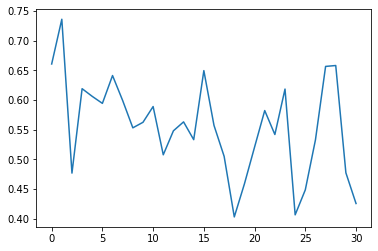

In [ ]:
plt.plot(losses_bpe2_en)

In [ ]:
print('Finnish classifier')
model_bpe2_fi = BinaryClassifier(num_labels, num_features)
optimizer = optim.Adam(model_bpe2_fi.parameters(), lr=learning_rate)

model_bpe2_fi, losses_bpe2_fi = train_loop(train_loader_fi, model_bpe2_fi, loss_function, optimizer, epochs, X_test_fi, y_test_fi)
print('Done!')

Finnish classifier
epoch: 0 loss: 0.338918 accuracy: 0.673191
epoch: 1 loss: 0.549840 accuracy: 0.689798
epoch: 2 loss: 0.500782 accuracy: 0.692171
epoch: 3 loss: 0.504521 accuracy: 0.693950
epoch: 4 loss: 0.447171 accuracy: 0.696323
epoch: 5 loss: 0.226185 accuracy: 0.696916
epoch: 6 loss: 0.350402 accuracy: 0.695136
epoch: 7 loss: 0.623265 accuracy: 0.700474
epoch: 8 loss: 0.591237 accuracy: 0.698695
epoch: 9 loss: 0.721920 accuracy: 0.703440
epoch: 10 loss: 0.526502 accuracy: 0.695136
epoch: 11 loss: 0.130774 accuracy: 0.697509
epoch: 12 loss: 0.425605 accuracy: 0.696916
epoch: 13 loss: 0.511723 accuracy: 0.702847
epoch: 14 loss: 0.300352 accuracy: 0.695730
epoch: 15 loss: 0.323232 accuracy: 0.704033
epoch: 16 loss: 0.168753 accuracy: 0.703440
epoch: 17 loss: 0.688641 accuracy: 0.695136
epoch: 18 loss: 0.931047 accuracy: 0.705219
epoch: 19 loss: 0.514091 accuracy: 0.701068
epoch: 20 loss: 0.495472 accuracy: 0.699288
epoch: 21 loss: 0.375804 accuracy: 0.700474
epoch: 22 loss: 0.14493

In [ ]:
print('Japanese classifier')
model_bpe2_ja = BinaryClassifier(num_labels, num_features)
optimizer = optim.Adam(model_bpe2_ja.parameters(), lr=learning_rate)

model_bpe2_ja, losses_bpe2_ja = train_loop(train_loader_ja, model_bpe2_ja, loss_function, optimizer, epochs, X_test_ja, y_test_ja)
print('Done!')

Japanese classifier
epoch: 0 loss: 0.669396 accuracy: 0.644788
epoch: 1 loss: 0.545258 accuracy: 0.677606
epoch: 2 loss: 0.462777 accuracy: 0.684363
epoch: 3 loss: 0.602954 accuracy: 0.695946
epoch: 4 loss: 0.557918 accuracy: 0.695946
epoch: 5 loss: 0.809560 accuracy: 0.694015
epoch: 6 loss: 0.741124 accuracy: 0.691120
epoch: 7 loss: 0.502518 accuracy: 0.698842
epoch: 8 loss: 0.558714 accuracy: 0.693050
epoch: 9 loss: 0.676783 accuracy: 0.694015
epoch: 10 loss: 0.673956 accuracy: 0.694981
epoch: 11 loss: 0.433467 accuracy: 0.698842
epoch: 12 loss: 0.653768 accuracy: 0.692085
epoch: 13 loss: 0.507266 accuracy: 0.691120
epoch: 14 loss: 0.641325 accuracy: 0.697876
epoch: 15 loss: 0.628779 accuracy: 0.696911
epoch: 16 loss: 0.672269 accuracy: 0.699807
epoch: 17 loss: 0.679038 accuracy: 0.698842
epoch: 18 loss: 0.981270 accuracy: 0.701737
epoch: 19 loss: 0.721534 accuracy: 0.694015
epoch: 20 loss: 0.382815 accuracy: 0.702703
epoch: 21 loss: 0.845348 accuracy: 0.700772
epoch: 22 loss: 0.5052

# Assignment 3: Language modelling

[Link to exemple on Medium](https://swatimeena989.medium.com/distilbert-text-classification-using-keras-c1201d3a3d9d)

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, T5Tokenizer, AutoModelForMaskedLM, TrainingArguments, Trainer

In [ ]:
def get_data(dataset, include=['question_text'], to_Dataset=True):
  d = dataset.copy()

  d = d.rename(columns={'document_plaintext':'text', 'answerable_t':'label'})
  d = d[['text','label']+include]

  #d=d[d['label']==1]

  if to_Dataset:
    d = datasets.Dataset.from_pandas(d)

  return d

## 3.a Select and finetune LM (incl. evaluation)

In [ ]:
train_qa_en = get_data(train_en)
train_qa_fi = get_data(train_fi)
train_qa_ja = get_data(train_ja)

test_qa_en = get_data(test_en)
test_qa_fi = get_data(test_fi)
test_qa_ja = get_data(test_ja)

In [ ]:
dict_en = datasets.DatasetDict({'train':train_qa_en, 'test':test_qa_en})
dict_fi = datasets.DatasetDict({'train':train_qa_fi, 'test':test_qa_fi})
dict_ja = datasets.DatasetDict({'train':train_qa_ja, 'test':test_qa_ja})

In [ ]:
block_size = 128

def group_texts(examples):
    # Concatenate all texts.
    keys = ['attention_mask', 'input_ids']
    concatenated_examples = {k: sum(examples[k], []) for k in keys}
    total_length = len(concatenated_examples[list(keys)[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    # this is needed as the used dataset is a subclass of ClassificationDataset, which requires label as a field...
    result["label"] = result["input_ids"].copy()
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
training_args = TrainingArguments(
    "test-clm",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=1,
    max_steps=300
)

### English language model

In [ ]:
model_checkpoint = "distilgpt2"
LM_tokenizer_en = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
LM_model_en = AutoModelForCausalLM.from_pretrained(model_checkpoint).to(device)

#### Finetuning+ eval

In [ ]:
qa_en_tok = dict_en.map(lambda x: LM_tokenizer_en(x['text']), batched=True, num_proc=4, remove_columns=['text','__index_level_0__','question_text'])
qa_en_splits = dict_en.remove_columns(['label'])
qa_en_tok_lm = qa_en_tok.map(group_texts, batched=True, batch_size=1000, num_proc=4)
qa_en_tok_lm = qa_en_tok_lm.remove_columns(['label'])

#print(qa_en_tok_lm['test'][0])

#0:   0%|          | 0/2 [00:00<?, ?ba/s]

#1:   0%|          | 0/2 [00:00<?, ?ba/s]

#2:   0%|          | 0/2 [00:00<?, ?ba/s]

#3:   0%|          | 0/2 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1173 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3898 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1924 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1066 > 1024). Running this sequence through the model will result in indexing errors


#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1089 > 1024). Running this sequence through the model will result in indexing errors


#0:   0%|          | 0/2 [00:00<?, ?ba/s]

#1:   0%|          | 0/2 [00:00<?, ?ba/s]

#2:   0%|          | 0/2 [00:00<?, ?ba/s]

#3:   0%|          | 0/2 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
trainer_en = Trainer(
    model=LM_model_en,
    args=training_args,
    train_dataset=qa_en_tok_lm["train"],
    eval_dataset=qa_en_tok_lm["test"],
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
eval_results = trainer_en.evaluate()
print(f"Perplexity before fine-tune: {math.exp(eval_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 1031
  Batch size = 8


Perplexity before fine-tune: 50.51


In [ ]:
trainer_en.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7582
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 300


Epoch,Training Loss,Validation Loss
0,No log,3.793539


***** Running Evaluation *****
  Num examples = 1031
  Batch size = 8




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=300, training_loss=3.9831087239583334, metrics={'train_runtime': 64.4108, 'train_samples_per_second': 37.261, 'train_steps_per_second': 4.658, 'total_flos': 78389025177600.0, 'train_loss': 3.9831087239583334, 'epoch': 0.32})

In [ ]:
eval_results = trainer_en.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 1031
  Batch size = 8


Perplexity: 44.41


In [ ]:
LM_model_en.save_pretrained('LM_model_en')

Configuration saved in LM_model_en/config.json
Model weights saved in LM_model_en/pytorch_model.bin


In [ ]:
AutoModelForCausalLM.from_pretrained('./LM_model_en/')

loading configuration file ./LM_model_en/config.json
Model config GPT2Config {
  "_name_or_path": "./LM_model_en/",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dtype": "

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

### Finnish language model

In [ ]:
model_checkpoint = 'Finnish-NLP/gpt2-finnish'
LM_tokenizer_fi = AutoTokenizer.from_pretrained(model_checkpoint)
LM_model_fi = AutoModelForCausalLM.from_pretrained(model_checkpoint).to(device)

https://huggingface.co/Finnish-NLP/gpt2-finnish/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp6t_dtto4


storing https://huggingface.co/Finnish-NLP/gpt2-finnish/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/b2ab5b1308faaafc7722788cc846a6aafbd8021734dc2224a2fc8e433e63a148.fde9434cc16b628c5e3d90fe794ef39b4a38f0bc5efedd2d8819a00a4d2fd7e1
creating metadata file for /root/.cache/huggingface/transformers/b2ab5b1308faaafc7722788cc846a6aafbd8021734dc2224a2fc8e433e63a148.fde9434cc16b628c5e3d90fe794ef39b4a38f0bc5efedd2d8819a00a4d2fd7e1
https://huggingface.co/Finnish-NLP/gpt2-finnish/resolve/main/vocab.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmppeg18462


storing https://huggingface.co/Finnish-NLP/gpt2-finnish/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/66fb227f8ba8a793ea41575437c8945e6ab5efbffd1d2c16c58abbf3b1db6edd.5a86552c6b4bd8b6c209e8ac003ce5cf6d4a1a266192c6435e2ed7041d601c30
creating metadata file for /root/.cache/huggingface/transformers/66fb227f8ba8a793ea41575437c8945e6ab5efbffd1d2c16c58abbf3b1db6edd.5a86552c6b4bd8b6c209e8ac003ce5cf6d4a1a266192c6435e2ed7041d601c30
https://huggingface.co/Finnish-NLP/gpt2-finnish/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpcaspt9o4


storing https://huggingface.co/Finnish-NLP/gpt2-finnish/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/584b9ddc680fcbe2a781b662ba33fa9a27e8cd8fa53e4c7f3eb1f8b2ced4efb1.04f6ac2836da35a243add2dfff427cfd16fa8fa90c68cda76602e97186e02970
creating metadata file for /root/.cache/huggingface/transformers/584b9ddc680fcbe2a781b662ba33fa9a27e8cd8fa53e4c7f3eb1f8b2ced4efb1.04f6ac2836da35a243add2dfff427cfd16fa8fa90c68cda76602e97186e02970
https://huggingface.co/Finnish-NLP/gpt2-finnish/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp2ajjmy81


storing https://huggingface.co/Finnish-NLP/gpt2-finnish/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/ad2f5c457dc37ffabf6cdd0cf9dfe0727af242b88dc339a51a3ae05d5a7a0c6f.da9c4826c2c358eb5d08e603b062ad99a4abac3fa43ff7b31d248cef449e29c7
creating metadata file for /root/.cache/huggingface/transformers/ad2f5c457dc37ffabf6cdd0cf9dfe0727af242b88dc339a51a3ae05d5a7a0c6f.da9c4826c2c358eb5d08e603b062ad99a4abac3fa43ff7b31d248cef449e29c7
https://huggingface.co/Finnish-NLP/gpt2-finnish/resolve/main/added_tokens.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpoct34srv


storing https://huggingface.co/Finnish-NLP/gpt2-finnish/resolve/main/added_tokens.json in cache at /root/.cache/huggingface/transformers/8ac811c200f8c1e457c6463adf830599e1ad4863888335ea336cc4f5dbb47b8f.96c5d6ee3b47c84194a9df186239e69d3987f151b8b35ff90f003aa2a2d14f64
creating metadata file for /root/.cache/huggingface/transformers/8ac811c200f8c1e457c6463adf830599e1ad4863888335ea336cc4f5dbb47b8f.96c5d6ee3b47c84194a9df186239e69d3987f151b8b35ff90f003aa2a2d14f64
https://huggingface.co/Finnish-NLP/gpt2-finnish/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp6hqg3b4m


storing https://huggingface.co/Finnish-NLP/gpt2-finnish/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/ac8be6bbd8f0694e4c935164a5843a9f5c80a572bc102eb2259e89cba78194ca.fbf4061fb19cfc48adf3510a9b4a6037fcf9cdf64fbdb306b328bafb3092779b
creating metadata file for /root/.cache/huggingface/transformers/ac8be6bbd8f0694e4c935164a5843a9f5c80a572bc102eb2259e89cba78194ca.fbf4061fb19cfc48adf3510a9b4a6037fcf9cdf64fbdb306b328bafb3092779b
loading file https://huggingface.co/Finnish-NLP/gpt2-finnish/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/66fb227f8ba8a793ea41575437c8945e6ab5efbffd1d2c16c58abbf3b1db6edd.5a86552c6b4bd8b6c209e8ac003ce5cf6d4a1a266192c6435e2ed7041d601c30
loading file https://huggingface.co/Finnish-NLP/gpt2-finnish/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/584b9ddc680fcbe2a781b662ba33fa9a27e8cd8fa53e4c7f3eb1f8b2ced4efb1.04f6ac2836da35a243add2dfff427cfd16fa8fa90c68cda76602e97186e0297

storing https://huggingface.co/Finnish-NLP/gpt2-finnish/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/49ccc9718c0ebe4cdd377af1547b0f516e103c6aa8c87b67e5b0a158f7a82752.91b903cbb3e9e8b31a21846716de99fec86b01a0dbf8a6a767e4654f699a90f2
creating metadata file for /root/.cache/huggingface/transformers/49ccc9718c0ebe4cdd377af1547b0f516e103c6aa8c87b67e5b0a158f7a82752.91b903cbb3e9e8b31a21846716de99fec86b01a0dbf8a6a767e4654f699a90f2
loading configuration file https://huggingface.co/Finnish-NLP/gpt2-finnish/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/49ccc9718c0ebe4cdd377af1547b0f516e103c6aa8c87b67e5b0a158f7a82752.91b903cbb3e9e8b31a21846716de99fec86b01a0dbf8a6a767e4654f699a90f2
Model config GPT2Config {
  "_name_or_path": "Finnish-NLP/gpt2-finnish",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializ

storing https://huggingface.co/Finnish-NLP/gpt2-finnish/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/720cbe7b3689032396e41a67597ec06f196cf681bab0d1cd6809183744431eef.9c5181488c5c95e2c73642dee9b9af9d30213d740505fbc5d1854b1da79d2d3a
creating metadata file for /root/.cache/huggingface/transformers/720cbe7b3689032396e41a67597ec06f196cf681bab0d1cd6809183744431eef.9c5181488c5c95e2c73642dee9b9af9d30213d740505fbc5d1854b1da79d2d3a
loading weights file https://huggingface.co/Finnish-NLP/gpt2-finnish/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/720cbe7b3689032396e41a67597ec06f196cf681bab0d1cd6809183744431eef.9c5181488c5c95e2c73642dee9b9af9d30213d740505fbc5d1854b1da79d2d3a
All model checkpoint weights were used when initializing GPT2LMHeadModel.

All the weights of GPT2LMHeadModel were initialized from the model checkpoint at Finnish-NLP/gpt2-finnish.
If your task is similar to the task the model of the checkpoint was traine

#### Finetuning + eval

In [ ]:
qa_fi_tok = dict_fi.map(lambda x: LM_tokenizer_fi(x['text']), batched=True, num_proc=4, remove_columns=['text','__index_level_0__','question_text'])
qa_fi_splits = dict_fi.remove_columns(['label'])
qa_fi_tok_lm = qa_fi_tok.map(group_texts, batched=True, batch_size=1000, num_proc=4)
qa_fi_tok_lm = qa_fi_tok_lm.remove_columns(['label'])

#print(qa_fi_tok_lm['test'][0])

#0:   0%|          | 0/4 [00:00<?, ?ba/s]

#1:   0%|          | 0/4 [00:00<?, ?ba/s]

#2:   0%|          | 0/4 [00:00<?, ?ba/s]

#3:   0%|          | 0/4 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

#0:   0%|          | 0/4 [00:00<?, ?ba/s]

#1:   0%|          | 0/4 [00:00<?, ?ba/s]

#2:   0%|          | 0/4 [00:00<?, ?ba/s]

#3:   0%|          | 0/4 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
trainer_fi = Trainer(
    model=LM_model_fi,
    args=training_args,
    train_dataset=qa_fi_tok_lm["train"],
    eval_dataset=qa_fi_tok_lm["test"],
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
eval_results = trainer_fi.evaluate()
print(f"Perplexity before fine-tune: {math.exp(eval_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 1487
  Batch size = 8


Perplexity before fine-tune: 19789662094.37


In [ ]:
trainer_fi.train()

***** Running training *****
  Num examples = 11425
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 300


Epoch,Training Loss,Validation Loss
0,No log,4.500673


***** Running Evaluation *****
  Num examples = 1487
  Batch size = 8




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=300, training_loss=6.4441300455729165, metrics={'train_runtime': 107.7906, 'train_samples_per_second': 22.265, 'train_steps_per_second': 2.783, 'total_flos': 156775219200000.0, 'train_loss': 6.4441300455729165, 'epoch': 0.21})

In [ ]:
eval_results = trainer_fi.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 1487
  Batch size = 8


Perplexity: 90.08


In [ ]:
LM_model_fi.save_pretrained('LM_model_fi')

Configuration saved in LM_model_fi/config.json
Model weights saved in LM_model_fi/pytorch_model.bin


### Japanese language model

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model_checkpoint = 'rinna/japanese-gpt2-small'
LM_tokenizer_ja = T5Tokenizer.from_pretrained(model_checkpoint)
LM_model_ja = AutoModelForCausalLM.from_pretrained(model_checkpoint).to(device)

https://huggingface.co/rinna/japanese-gpt2-small/resolve/main/spiece.model not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp5k4jswf1


storing https://huggingface.co/rinna/japanese-gpt2-small/resolve/main/spiece.model in cache at /root/.cache/huggingface/transformers/d22119c30bc106b290ef639d61c14ee4df55beda7ad6b2e258932e5a270908a2.c0b735c65f40dff8596b5f699043bb29048036242443fea32b79a9dd8510ea96
creating metadata file for /root/.cache/huggingface/transformers/d22119c30bc106b290ef639d61c14ee4df55beda7ad6b2e258932e5a270908a2.c0b735c65f40dff8596b5f699043bb29048036242443fea32b79a9dd8510ea96
https://huggingface.co/rinna/japanese-gpt2-small/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpp0kvllzc


storing https://huggingface.co/rinna/japanese-gpt2-small/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/96f1ddf7247675414b491c5c3ae4c7ac307cf28d0f90977b7cbdf13a8f84bfc8.9049458ebcd1cf666b7b0a046aa394597f12e611077571cfc86e0938f8675d82
creating metadata file for /root/.cache/huggingface/transformers/96f1ddf7247675414b491c5c3ae4c7ac307cf28d0f90977b7cbdf13a8f84bfc8.9049458ebcd1cf666b7b0a046aa394597f12e611077571cfc86e0938f8675d82
https://huggingface.co/rinna/japanese-gpt2-small/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpsn_6wfqz


storing https://huggingface.co/rinna/japanese-gpt2-small/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/f58aaff203818bdc42aa91ed2a00a99b97cd62db4b09c36e93903f6e95fba3bc.9c6d86638d0c8b0d39297c982899c13374e883f6e85a7c2c9baad32a40abf7dd
creating metadata file for /root/.cache/huggingface/transformers/f58aaff203818bdc42aa91ed2a00a99b97cd62db4b09c36e93903f6e95fba3bc.9c6d86638d0c8b0d39297c982899c13374e883f6e85a7c2c9baad32a40abf7dd
loading file https://huggingface.co/rinna/japanese-gpt2-small/resolve/main/spiece.model from cache at /root/.cache/huggingface/transformers/d22119c30bc106b290ef639d61c14ee4df55beda7ad6b2e258932e5a270908a2.c0b735c65f40dff8596b5f699043bb29048036242443fea32b79a9dd8510ea96
loading file https://huggingface.co/rinna/japanese-gpt2-small/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/rinna/japanese-gpt2-small/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/

storing https://huggingface.co/rinna/japanese-gpt2-small/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/f57ebfd37e088140858c25efd76026dba0044e364b7afd55f2cf592598e37324.d7f8d739b24053db52ad34244d36a3df6a930153af5d4a1445ac61cac8bf8bc3
creating metadata file for /root/.cache/huggingface/transformers/f57ebfd37e088140858c25efd76026dba0044e364b7afd55f2cf592598e37324.d7f8d739b24053db52ad34244d36a3df6a930153af5d4a1445ac61cac8bf8bc3
loading configuration file https://huggingface.co/rinna/japanese-gpt2-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f57ebfd37e088140858c25efd76026dba0044e364b7afd55f2cf592598e37324.d7f8d739b24053db52ad34244d36a3df6a930153af5d4a1445ac61cac8bf8bc3
Model config GPT2Config {
  "_name_or_path": "rinna/japanese-gpt2-small",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 1,
  "embd_pdrop": 0.1,
  "eos_token_id": 2,
  "gradient_check

storing https://huggingface.co/rinna/japanese-gpt2-small/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/08dce51a6284b7dfd687564d1c972f9a499e246d34d08a6344a271d6913cf3f5.1f6f511ba62456bd0ab11dc83c05711adfb07d790dbf93d77ad761e1b1c03e19
creating metadata file for /root/.cache/huggingface/transformers/08dce51a6284b7dfd687564d1c972f9a499e246d34d08a6344a271d6913cf3f5.1f6f511ba62456bd0ab11dc83c05711adfb07d790dbf93d77ad761e1b1c03e19
loading weights file https://huggingface.co/rinna/japanese-gpt2-small/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/08dce51a6284b7dfd687564d1c972f9a499e246d34d08a6344a271d6913cf3f5.1f6f511ba62456bd0ab11dc83c05711adfb07d790dbf93d77ad761e1b1c03e19
All model checkpoint weights were used when initializing GPT2LMHeadModel.

All the weights of GPT2LMHeadModel were initialized from the model checkpoint at rinna/japanese-gpt2-small.
If your task is similar to the task the model of the checkpoint was tra

#### Finetuning + eval

In [ ]:
qa_ja_tok = dict_ja.map(lambda x: LM_tokenizer_ja(x['text']), batched=True, num_proc=4, remove_columns=['text','__index_level_0__','question_text'])
qa_ja_splits = dict_ja.remove_columns(['label'])
qa_ja_tok_lm = qa_ja_tok.map(group_texts, batched=True, batch_size=1000, num_proc=4)
qa_ja_tok_lm = qa_ja_tok_lm.remove_columns(['label'])

#print(qa_ja_tok_lm['test'][0])

#0:   0%|          | 0/3 [00:00<?, ?ba/s]

#1:   0%|          | 0/3 [00:00<?, ?ba/s]

#2:   0%|          | 0/3 [00:00<?, ?ba/s]

#3:   0%|          | 0/3 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#0:   0%|          | 0/3 [00:00<?, ?ba/s]

#1:   0%|          | 0/3 [00:00<?, ?ba/s]

#2:   0%|          | 0/3 [00:00<?, ?ba/s]

#3:   0%|          | 0/3 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
trainer_ja = Trainer(
    model=LM_model_ja,
    args=training_args,
    train_dataset=qa_ja_tok_lm["train"],
    eval_dataset=qa_ja_tok_lm["test"],
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
eval_results = trainer_ja.evaluate()
print(f"Perplexity before fine-tune: {math.exp(eval_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 980
  Batch size = 8


Perplexity before fine-tune: 62.38


In [ ]:
trainer_ja.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9090
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 300


Epoch,Training Loss,Validation Loss
0,No log,3.793010


***** Running Evaluation *****
  Num examples = 980
  Batch size = 8




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=300, training_loss=3.9355647786458334, metrics={'train_runtime': 100.0938, 'train_samples_per_second': 23.978, 'train_steps_per_second': 2.997, 'total_flos': 156775219200000.0, 'train_loss': 3.9355647786458334, 'epoch': 0.26})

In [ ]:
eval_results = trainer_ja.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 980
  Batch size = 8


Perplexity: 44.39


In [ ]:
LM_model_ja.save_pretrained('LM_model_ja')

Configuration saved in LM_model_ja/config.json
Model weights saved in LM_model_ja/pytorch_model.bin


## 3.b Sampling from language models

In [ ]:
def sampling_LM(model, tokenizer, input_ids):
  output = tokenizer.decode(model.generate(input_ids, max_length=50)[0], skip_special_tokens=True)
  print('Greedy Search:', output)

  output = tokenizer.decode(model.generate(input_ids, max_length=50, num_beams=5)[0], skip_special_tokens=True)
  print('Beam Search:', output)

  output = tokenizer.decode(model.generate(input_ids, max_length=50, no_repeat_ngram_size=2)[0], skip_special_tokens=True)
  print('N-gram penality:', output)

  output = tokenizer.decode(model.generate(input_ids, max_length=50, top_k=50)[0], skip_special_tokens=True)
  print('Top-K Sampling:', output)

English language model

In [ ]:
input_ids = LM_tokenizer_en.encode('What is', return_tensors='pt').to(device)

sampling_LM(LM_model_en, LM_tokenizer_en, input_ids)
output = LM_model_en.generate(input_ids, max_length=50, num_beams=5, num_return_sequences=5, no_repeat_ngram_size=2, do_sample=True, top_k=50)#, top_p=.99)

for i, beam_output in enumerate(output):
  print("{}: {}".format(i, LM_tokenizer_en.decode(beam_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Greedy Search: What is the first time that a person has been arrested for a crime in the United States. The first time that a person has been arrested for a crime in the United States. The first time that a person has been arrested for a crime in the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Beam Search: What is the first time in the history of the United States of America that the United States of America has become the first country in the world to become the first country in the world to become the first country in the world to become the first country in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


N-gram penality: What is the first time that a person has been arrested for a crime in the United States. The first is a case of a man being arrested in a state of emergency, and the second is an arrest of an individual who is being held in custody


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Top-K Sampling: What is the first time that a person has been arrested for a crime in the United States. The first time that a person has been arrested for a crime in the United States. The first time that a person has been arrested for a crime in the
0: What is the only game in the series to feature a single player. The game was released in 1998 and was one of the most successful games of all time. It was the first game of its kind in North America, and it was developed by the
1: What is the first time a person has been arrested for a crime in the United States. It is also the second time an individual has had a conviction for an offence committed by a police officer.
The American Civil Liberties Union (ACLU) is
2: What is a game that can be played in a single game. It is the first game of its kind in the history of the United States, and it is one of only a handful of games that have been released since the 17th century. The
3: What is the name of the University of North Carolina-Cha

Finnish language model

In [ ]:
input_ids = LM_tokenizer_fi.encode(' ', return_tensors='pt').to(device)

sampling_LM(LM_model_fi, LM_tokenizer_fi, input_ids)
output = LM_model_fi.generate(input_ids, max_length=50, num_beams=5, num_return_sequences=5, no_repeat_ngram_size=2, do_sample=True, top_k=50)#, top_p=.99)

for i, oo in enumerate(output):
  print("{}: {}".format(i, LM_tokenizer_fi.decode(oo, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Greedy Search:   män�män�män� män� män� ] ] ] ] ] ] ] ] ] ] ] ] ] ] ] ] ] ] ] ] 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Beam Search:   ipuolueet ovat olleet erimielisiä siitä, olivatko ne saaneet sovittua vaaliliitot, mutta ne eivät olleet yksimielisiä siitä, olivatko ne päässeet yhteisymmärrykseen vaaliliitoista. Puolueen johtohahmot olivat erimielisiä siitä, olivatko ne päässeet


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


N-gram penality:   män�män� ] � � [ 
 � � ter� � | { � � � � � � } � � � � �


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Top-K Sampling:   män�män�män� män� män� ] ] ] ] ] ] ] ] ] ] ] ] ] ] ] ] ] ] ] ] 
0:   män� � ] � [ � 
 � � � { � � ter� � � � | � � � � � � 
1:   män� [ � ] � � 
 � { ter� � | � � � � � � } � � � � � 
2:   män� � � � ] [ | 
 ter� � � � { � � � � � � � � � � � 
3:   män� { ] � � � | [ � 
 � � � � ter� � � � � � � � � � 
4:   män� � ] � � [ � ter� 
 � � � { � � � � � | � � � � � 


Japanese language model

In [ ]:
input_ids = LM_tokenizer_ja.encode('日本', return_tensors='pt').to(device)

sampling_LM(LM_model_ja, LM_tokenizer_ja, input_ids)
output = LM_model_ja.generate(input_ids, max_length=50, num_beams=5, num_return_sequences=5, no_repeat_ngram_size=2, do_sample=True, top_k=50)#, top_p=.99)

for i, oo in enumerate(output):
  print("{}: {}".format(i, LM_tokenizer_ja.decode(oo, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Greedy Search: 日本1月 - 1月、2月 - 3月、4月 - 5月、6月 - 7月、8月 - 9月、10月 - 11月 - 12月、1月 - 2月、3月


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Beam Search: 日本2019年(平成31年/令和元年)度 - 2019年(平成31年/令和元年)度 - 2019年(平成31年/令和元年)度 - 2019年(平成31年/令和元年


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


N-gram penality: 日本1月 - 1st mini album「the idolm@ster cinderella girls master artist collector's box」発売。 2月1日 - 2nd


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Top-K Sampling: 日本1月 - 1月、2月 - 3月、4月 - 5月、6月 - 7月、8月 - 9月、10月 - 11月 - 12月、1月 - 2月、3月
0: 日本1月13日 - 第1回卒業証書授与式を挙行。 2月 - 創立記念日を制定。 4月1日(月) - 東京女子高等師範学校附属小学校(現・筑波大学附属中学校・高等学校)
1: 日本1月1日 - 大阪市生野区(現・中央区)生野町1丁目1番1号に新大阪ビルが竣工。 3月 - 大阪証券取引所市場第2部に株式を上場。 6月22日
2: 日本1月1日 - 日本国有鉄道(国鉄)発足。 旅客営業開始。 2月 - 東京急行電鉄(現・東急電鉄)が設立。 3月31日 国鉄の分割・民営化により、東海旅客鉄道(
3: 日本2020年10月1日 - 新型コロナウイルス感染症(covid-19)の流行に伴い、当院では診療時間を変更します。 ご迷惑をおかけしますが、ご理解のほどよろしくお願い
4: 日本2019年(平成31年)4月1日現在。 起点:岐阜県可児郡御嵩町 終点:愛知県安城市 総延長:9. 0km 重用延長:0. 1km 2015年4


## 3.e Final hidden layer or pooled representation

### Defining utilities functions

In [ ]:
def mean_pooling(model_output, attention_mask):
  # Mean Pooling, take attention mask into account for correct average
  input_mask_expanded = attention_mask.unsqueeze(-1).expand(model_output.size()).float()
  sum_embeddings = torch.sum(model_output * input_mask_expanded, 1)
  sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)

  return sum_embeddings / sum_mask

Next step: Convert into suitable tensors. run mean pooling. feed into binary model.

In [ ]:
def prepare_data(dic, tokenizer, lm_model):
  dat = []
  with torch.no_grad():
    for i in tqdm(range(len(dic['question_text']))):
      encodedBis = tokenizer([dic['question_text'][i]], return_tensors='pt', padding=True)
      encodedBis = {k:v.to(device) for k, v in encodedBis.items()}
      model_output = lm_model(**encodedBis, output_hidden_states=True, return_dict=True)
      mean_model_output = mean_pooling(model_output['hidden_states'][-1], encodedBis['attention_mask'])

      dat.append(mean_model_output.cpu())
  return dat

Assigning [PAD] to the pad_token key of the tokenizer


In [ ]:
LM_tokenizer_en.add_special_tokens({'pad_token': '[PAD]'})
LM_tokenizer_fi.add_special_tokens({'pad_token': '[PAD]'})
LM_tokenizer_ja.add_special_tokens({'pad_token': '[PAD]'})

Assigning [PAD] to the pad_token key of the tokenizer
Assigning [PAD] to the pad_token key of the tokenizer
Assigning [PAD] to the pad_token key of the tokenizer


0

In [ ]:
def vec_to_col(df, feature):
  df = pd.concat([df, df[feature].apply(pd.Series)], axis=1)
  df.columns = ['LM_' + str(x) if is_number(x) else x for x in df.columns]
  return df


In [ ]:
def pipeline_hidden_state(ds: datasets.arrow_dataset.Dataset, tokenizer, lm_model):
  hiddens = prepare_data(ds, tokenizer, lm_model)
  df = pd.DataFrame(ds)
  df["last_hidden_state"] = hiddens
  df["last_hidden_state"] = df["last_hidden_state"].progress_apply(lambda x: x[0])
  df = vec_to_col(df, 'last_hidden_state')
  return df

### Preprocessing the data

In [ ]:
train_lm_en = pipeline_hidden_state(dict_en['train'], LM_tokenizer_en, LM_model_en)
test_lm_en = pipeline_hidden_state(dict_en['test'], LM_tokenizer_en, LM_model_en)

train_lm_fi = pipeline_hidden_state(dict_fi['train'], LM_tokenizer_fi, LM_model_fi)
test_lm_fi = pipeline_hidden_state(dict_fi['test'], LM_tokenizer_fi, LM_model_fi)

train_lm_ja = pipeline_hidden_state(dict_ja['train'], LM_tokenizer_ja, LM_model_ja)
test_lm_ja = pipeline_hidden_state(dict_ja['test'], LM_tokenizer_ja, LM_model_ja)

100%|██████████| 1036/1036 [00:00<00:00, 203488.76it/s]


### Training

#### Only the final hidden state as features

In [ ]:
vars = ['LM_' + str(i) for i in range(0,768)]

X_train_en, y_train_en, train_loader_en, X_test_en, y_test_en, test_loader_en = train_test(train_lm_en, test_lm_en, vars, 'label')
X_train_fi, y_train_fi, train_loader_fi, X_test_fi, y_test_fi, test_loader_fi = train_test(train_lm_fi, test_lm_fi, vars, 'label')
X_train_ja, y_train_ja, train_loader_ja, X_test_ja, y_test_ja, test_loader_ja = train_test(train_lm_ja, test_lm_ja, vars, 'label')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
num_features = len(vars)
epochs=300
learning_rate=0.001
num_labels=2
loss_function = nn.BCELoss()

In [ ]:
print('English classifier')
model_hs_en = BinaryClassifier(num_labels, num_features)
optimizer = optim.Adam(model_hs_en.parameters(), lr=learning_rate)

model_hs_en, losses_hs_en = train_loop(train_loader_en, model_hs_en, loss_function, optimizer, epochs, X_test_en, y_test_en)
print('Done!')

English classifier
epoch: 0 loss: 0.694143 accuracy: 0.500000
epoch: 1 loss: 0.690123 accuracy: 0.500000
epoch: 2 loss: 0.695826 accuracy: 0.500000
epoch: 3 loss: 0.695483 accuracy: 0.500000
epoch: 4 loss: 0.689176 accuracy: 0.500000
epoch: 5 loss: 0.693195 accuracy: 0.500000
epoch: 6 loss: 0.691380 accuracy: 0.500000
epoch: 7 loss: 0.689794 accuracy: 0.500000
epoch: 8 loss: 0.693275 accuracy: 0.500000
epoch: 9 loss: 0.695045 accuracy: 0.500000
epoch: 10 loss: 0.698109 accuracy: 0.500000
Best accuracy: 0.5
Done!


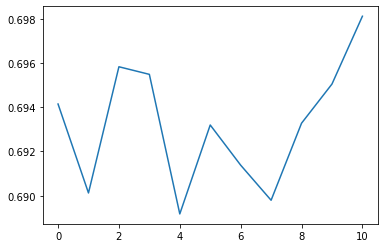

In [ ]:
plt.plot(losses_hs_en)

In [ ]:
print('Finnish classifier')
model_hs_fi = BinaryClassifier(num_labels, num_features)
optimizer = optim.Adam(model_hs_fi.parameters(), lr=learning_rate)

model_hs_fi, losses_hs_fi = train_loop(train_loader_fi, model_hs_fi, loss_function, optimizer, epochs, X_test_fi, y_test_fi, patience = 30)
print('Done!')

Finnish classifier
epoch: 0 loss: 0.700025 accuracy: 0.500000
epoch: 1 loss: 0.700784 accuracy: 0.500000
epoch: 2 loss: 0.689359 accuracy: 0.500000
epoch: 3 loss: 0.691685 accuracy: 0.500000
epoch: 4 loss: 0.692937 accuracy: 0.500000
epoch: 5 loss: 0.693357 accuracy: 0.500000
epoch: 6 loss: 0.692766 accuracy: 0.500000
epoch: 7 loss: 0.694492 accuracy: 0.500000
epoch: 8 loss: 0.695741 accuracy: 0.500000
epoch: 9 loss: 0.693128 accuracy: 0.500000
epoch: 10 loss: 0.694264 accuracy: 0.500000
epoch: 11 loss: 0.693856 accuracy: 0.500000
epoch: 12 loss: 0.692958 accuracy: 0.500000
epoch: 13 loss: 0.692686 accuracy: 0.500000
epoch: 14 loss: 0.692281 accuracy: 0.500000
epoch: 15 loss: 0.691105 accuracy: 0.500000
epoch: 16 loss: 0.692490 accuracy: 0.500000
epoch: 17 loss: 0.693140 accuracy: 0.500000
epoch: 18 loss: 0.694050 accuracy: 0.500000
epoch: 19 loss: 0.691981 accuracy: 0.500000
epoch: 20 loss: 0.692255 accuracy: 0.500000
epoch: 21 loss: 0.688004 accuracy: 0.500000
epoch: 22 loss: 0.68895

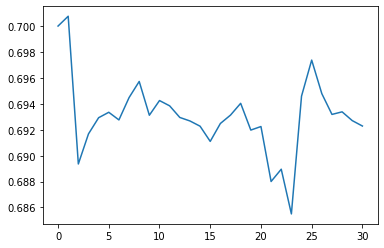

In [ ]:
plt.plot(losses_hs_fi)

In [ ]:
print('Japanese classifier')
model_hs_ja = BinaryClassifier(num_labels, num_features)
optimizer = optim.Adam(model_hs_ja.parameters(), lr=learning_rate)

model_hs_ja, losses_hs_ja = train_loop(train_loader_ja, model_hs_ja, loss_function, optimizer, epochs, X_test_ja, y_test_ja, patience = 30)
print('Done!')

Japanese classifier
epoch: 0 loss: 0.688927 accuracy: 0.500000
epoch: 1 loss: 0.701484 accuracy: 0.500000
epoch: 2 loss: 0.691241 accuracy: 0.500000
epoch: 3 loss: 0.687264 accuracy: 0.500000
epoch: 4 loss: 0.700893 accuracy: 0.500000
epoch: 5 loss: 0.709440 accuracy: 0.500000
epoch: 6 loss: 0.690910 accuracy: 0.500000
epoch: 7 loss: 0.695119 accuracy: 0.500000
epoch: 8 loss: 0.696840 accuracy: 0.500000
epoch: 9 loss: 0.692300 accuracy: 0.500000
epoch: 10 loss: 0.693729 accuracy: 0.500000
epoch: 11 loss: 0.693147 accuracy: 0.500000
epoch: 12 loss: 0.691665 accuracy: 0.500000
epoch: 13 loss: 0.693233 accuracy: 0.500000
epoch: 14 loss: 0.692852 accuracy: 0.500000
epoch: 15 loss: 0.693152 accuracy: 0.500000
epoch: 16 loss: 0.693175 accuracy: 0.500000
epoch: 17 loss: 0.692814 accuracy: 0.500000
epoch: 18 loss: 0.693147 accuracy: 0.500000
epoch: 19 loss: 0.693903 accuracy: 0.500000
epoch: 20 loss: 0.693428 accuracy: 0.500000
epoch: 21 loss: 0.693152 accuracy: 0.500000
epoch: 22 loss: 0.6932

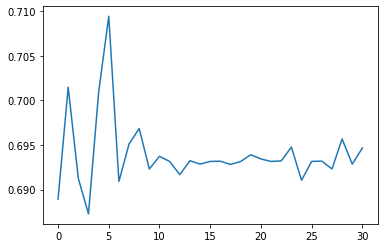

In [ ]:
plt.plot(losses_hs_ja)

Again that weird thing happening, the parameters seem stuck and don't update

#### Extending the classifier

In [ ]:
all_features_train_en = pd.concat([train_en.reset_index(drop=True), train_lm_en.reset_index(drop=True)], axis=1, ignore_index=True)
all_features_test_en = pd.concat([test_en.reset_index(drop=True), test_lm_en.reset_index(drop=True)], axis=1, ignore_index=True)
all_features_train_en.columns = list(train_en.columns) + list(train_lm_en.columns)
all_features_test_en.columns = list(test_en.columns) + list(test_lm_en.columns)

all_features_train_fi = pd.concat([train_fi.reset_index(drop=True), train_lm_fi.reset_index(drop=True)], axis=1, ignore_index=True)
all_features_test_fi = pd.concat([test_fi.reset_index(drop=True), test_lm_fi.reset_index(drop=True)], axis=1, ignore_index=True)
all_features_train_fi.columns = list(train_fi.columns) + list(train_lm_fi.columns)
all_features_test_fi.columns = list(test_fi.columns) + list(test_lm_fi.columns)

all_features_train_ja = pd.concat([train_ja.reset_index(drop=True), train_lm_ja.reset_index(drop=True)], axis=1, ignore_index=True)
all_features_test_ja = pd.concat([test_ja.reset_index(drop=True), test_lm_ja.reset_index(drop=True)], axis=1, ignore_index=True)
all_features_train_ja.columns = list(train_ja.columns) + list(train_lm_ja.columns)
all_features_test_ja.columns = list(test_ja.columns) + list(test_lm_ja.columns)

In [ ]:
vars = ['occurrences','BOW_mean','cos_bow','TFIDF1_mean','cos_TFIDF'] + ['LM_' + str(i) for i in range(0,768)]

X_train_en, y_train_en, train_loader_en, X_test_en, y_test_en, test_loader_en = train_test(all_features_train_en, all_features_test_en, vars, 'label')
X_train_fi, y_train_fi, train_loader_fi, X_test_fi, y_test_fi, test_loader_fi = train_test(all_features_train_fi, all_features_test_fi, vars, 'label')
X_train_ja, y_train_ja, train_loader_ja, X_test_ja, y_test_ja, test_loader_ja = train_test(all_features_train_ja, all_features_test_ja, vars, 'label')

In [ ]:
num_features = len(vars)
epochs=300
learning_rate=0.001
num_labels=2
loss_function = nn.BCELoss()

In [ ]:
print('English classifier')
model_hs_en = BinaryClassifier(num_labels, num_features)
optimizer = optim.Adam(model_hs_en.parameters(), lr=learning_rate)

model_hs_en, losses_hs_en = train_loop(train_loader_en, model_hs_en, loss_function, optimizer, epochs, X_test_en, y_test_en)
print('Done!')

English classifier
epoch: 0 loss: 0.672324 accuracy: 0.500000
epoch: 1 loss: 0.685122 accuracy: 0.500000
epoch: 2 loss: 0.693726 accuracy: 0.500000
epoch: 3 loss: 0.691261 accuracy: 0.552525
epoch: 4 loss: 0.681514 accuracy: 0.500000
epoch: 5 loss: 0.686889 accuracy: 0.503030
epoch: 6 loss: 0.689827 accuracy: 0.505051
epoch: 7 loss: 0.688761 accuracy: 0.655556
epoch: 8 loss: 0.680799 accuracy: 0.601010
epoch: 9 loss: 0.643149 accuracy: 0.676768
epoch: 10 loss: 0.660724 accuracy: 0.571717
epoch: 11 loss: 0.669000 accuracy: 0.703030
epoch: 12 loss: 0.702298 accuracy: 0.611111
epoch: 13 loss: 0.514444 accuracy: 0.653535
epoch: 14 loss: 0.597430 accuracy: 0.694949
epoch: 15 loss: 0.664049 accuracy: 0.645455
epoch: 16 loss: 0.581609 accuracy: 0.701010
epoch: 17 loss: 0.652049 accuracy: 0.668687
epoch: 18 loss: 0.659522 accuracy: 0.633333
epoch: 19 loss: 0.594348 accuracy: 0.697980
epoch: 20 loss: 0.520322 accuracy: 0.687879
epoch: 21 loss: 0.617963 accuracy: 0.639394
Best accuracy: 0.703030

In [ ]:
print('Finnish classifier')
model_hs_fi = BinaryClassifier(num_labels, num_features)
optimizer = optim.Adam(model_hs_fi.parameters(), lr=learning_rate)
model_hs_fi, losses_hs_fi = train_loop(train_loader_fi, model_hs_fi, loss_function, optimizer, epochs, X_test_fi, y_test_fi, patience = 30)
print('Done!')

Finnish classifier
epoch: 0 loss: 0.685786 accuracy: 0.500000
epoch: 1 loss: 0.696237 accuracy: 0.500000
epoch: 2 loss: 0.691066 accuracy: 0.500000
epoch: 3 loss: 0.683835 accuracy: 0.500000
epoch: 4 loss: 0.695688 accuracy: 0.500000
epoch: 5 loss: 0.692968 accuracy: 0.500000
epoch: 6 loss: 0.693025 accuracy: 0.500000
epoch: 7 loss: 0.690402 accuracy: 0.500000
epoch: 8 loss: 0.693488 accuracy: 0.500000
epoch: 9 loss: 0.694953 accuracy: 0.500000
epoch: 10 loss: 0.694002 accuracy: 0.500000
epoch: 11 loss: 0.694270 accuracy: 0.500000
epoch: 12 loss: 0.694391 accuracy: 0.500000
epoch: 13 loss: 0.693404 accuracy: 0.500000
epoch: 14 loss: 0.694724 accuracy: 0.500000
epoch: 15 loss: 0.688399 accuracy: 0.500000
epoch: 16 loss: 0.693115 accuracy: 0.500000
epoch: 17 loss: 0.692406 accuracy: 0.500000
epoch: 18 loss: 0.693128 accuracy: 0.500000
epoch: 19 loss: 0.694290 accuracy: 0.500000
epoch: 20 loss: 0.693390 accuracy: 0.500000
epoch: 21 loss: 0.692280 accuracy: 0.500000
epoch: 22 loss: 0.69259

In [ ]:
print('Japanese classifier')
model_hs_ja = BinaryClassifier(num_labels, num_features)
optimizer = optim.Adam(model_hs_ja.parameters(), lr=learning_rate)

model_hs_ja, losses_hs_ja = train_loop(train_loader_ja, model_hs_ja, loss_function, optimizer, epochs, X_test_ja, y_test_ja, patience = 30)
print('Done!')

Japanese classifier
epoch: 0 loss: 0.686874 accuracy: 0.514479
epoch: 1 loss: 0.685859 accuracy: 0.507722
epoch: 2 loss: 0.698369 accuracy: 0.534749
epoch: 3 loss: 0.688718 accuracy: 0.559846
epoch: 4 loss: 0.680496 accuracy: 0.515444
epoch: 5 loss: 0.691076 accuracy: 0.529923
epoch: 6 loss: 0.655831 accuracy: 0.562741
epoch: 7 loss: 0.760238 accuracy: 0.629344
epoch: 8 loss: 0.618425 accuracy: 0.641892
epoch: 9 loss: 0.602799 accuracy: 0.640927
epoch: 10 loss: 0.684149 accuracy: 0.645753
epoch: 11 loss: 0.600720 accuracy: 0.636100
epoch: 12 loss: 0.730625 accuracy: 0.654440
epoch: 13 loss: 0.471702 accuracy: 0.651544
epoch: 14 loss: 0.665005 accuracy: 0.648649
epoch: 15 loss: 0.698247 accuracy: 0.662162
epoch: 16 loss: 0.475875 accuracy: 0.654440
epoch: 17 loss: 0.538215 accuracy: 0.648649
epoch: 18 loss: 0.452910 accuracy: 0.653475
epoch: 19 loss: 0.591738 accuracy: 0.639961
epoch: 20 loss: 0.676092 accuracy: 0.639961
epoch: 21 loss: 0.575909 accuracy: 0.640927
epoch: 22 loss: 0.5676

# Assignment 4: Error Analysis and Interpretability

Let's take the English model trained in 1.2.b and the one from 2.a. The second one achieving better performance than the first one.

In [ ]:
model_1_2b = model_en
model_2a = model_bpe_en

In [ ]:
vars1 = ['occurrences','BOW_mean','cos_bow','TFIDF1_mean','cos_TFIDF']
X_train_en_1, y_train_en_1, train_loader_en_1, X_test_en_1, y_test_en_1, test_loader_en_1 = train_test(train_en, test_en, vars1, 'answerable_t')

vars2 = ['occurrences','BOW_mean','cos_bow','TFIDF1_mean','cos_TFIDF'] + ['comb_bpemb_' + str(i) for i in range(0,100)]
X_train_en_2, y_train_en_2, train_loader_en_2, X_test_en_2, y_test_en_2, test_loader_en_2 = train_test(train_en, test_en, vars2, 'answerable_t')


Let's have a look at some examples first

In [ ]:
def get_wrong(model, df, vars):
  translate_result = ['Non-answerable', 'Answerable']
  wrong_indexes = []
  for i in tqdm(range(df.shape[0])):
    answer = df["answerable"].iloc[i]
    features = torch.FloatTensor(df[vars].iloc[i]).to(device)
    prediction = translate_result[int(model(features).cpu().detach().numpy().round()[0])]
    if answer != prediction:
      wrong_indexes.append(i)
  return wrong_indexes

In [ ]:
fk_idxs_1 = get_wrong(model_1_2b, test_en, vars1)
fk_idxs_2 = get_wrong(model_2a, test_en, vars2)

100%|██████████| 990/990 [00:01<00:00, 701.52it/s]


In [ ]:
len(fk_idxs_1), len(fk_idxs_2)

(315, 260)

## Examples

In [ ]:
list_index = [fk_idxs_1[206], fk_idxs_2[55], fk_idxs_1[64], fk_idxs_1[122]]
for idx in list_index:
  translate_result = ['Non-answerable', 'Answerable']

  question = test_en["question_text"].iloc[idx]
  context = test_en['document_plaintext'].iloc[idx]
  features_1 = torch.FloatTensor(test_en[vars1].iloc[idx]).to(device)
  features_2 = torch.FloatTensor(test_en[vars2].iloc[idx]).to(device)
  answer = test_en["answerable"].iloc[idx]

  prediction_1 = translate_result[int(model_1_2b(features_1).cpu().detach().numpy().round()[0])]
  prediction_2 = translate_result[int(model_2a(features_2).cpu().detach().numpy().round()[0])]
  print(f'{question}\nContext: {context}\nPrediction of the model 1: {prediction_1}\nPrediction of the model 2: {prediction_2}\nActual answer: {answer}')
  print("-"*50)

Who is president of the NFL?
Context: In 2014, Goodell was awarded the third highest honor within the Department of the Army Civilian Awards scheme, the Outstanding Civilian Service Award, for substantial contributions to the US Army community while serving as the NFL commissioner.[22]
Prediction of the model 1: Answerable
Prediction of the model 2: Non-answerable
Actual answer: Non-answerable
--------------------------------------------------
When were Roth IRAs created?
Context: The Roth IRA was established by the Taxpayer Relief Act of 1997 (Public Law 105-34) and named for its chief legislative sponsor, Senator William Roth of Delaware. In 2000, 46.3 million taxpayers held IRA accounts worth a total of $2.6 trillion in value according to the Internal Revenue Service (IRS). Only a little over $77 billion of that amount was held in Roth IRAs. By 2007, the number of IRA owners has jumped to over 50 million taxpayers with $3.3 trillion invested.[4]
Prediction of the model 1: Answerable

## Fool the model

In [ ]:
text = "The iPhone is a line of smartphones designed and marketed by Apple Inc. These devices use Apple's iOS mobile operating system. The first-generation iPhone was announced by then-Apple CEO Steve Jobs on January 9, 2007. Since then, Apple has annually released new iPhone models and iOS updates. As of November 1, 2018, more than 2.2 billion iPhones had been sold. As of 2022, the iPhone accounts for 15.6% of global smartphone market share."
question = "How to find jobs?"
answer = 'No'

def preprocess_input_en(question, text):
  text_t = tokenizer_lang(text, nlp_en, remove_stop=True)
  question_t = tokenizer_lang(question, nlp_en, remove_stop=True)
  occurrences = occurrence_counter(question_t, text_t)
  bow = CountVec.fit_transform([question, text]).toarray()
  bow1, bow2 = (bow[0], bow[1])
  bow_mean = bow1.mean()
  cos_bow = 1 - cosine(bow1, bow2)
  tfidf = tfidfvectorizer.fit_transform([question, text]).toarray()
  tfidf1, tfidf2 = (tfidf[0], tfidf[1])
  tfidf1_mean, tfidf2_mean = tfidf1.mean(), tfidf2.mean()
  cos_tfidf = 1 - cosine(tfidf1, tfidf2)

  features = [occurrences,bow_mean,cos_bow,tfidf1_mean,cos_tfidf]

  bpe_vec = list(bpemb_en.embed(question).mean(0))

  return features + bpe_vec

input = torch.FloatTensor(preprocess_input_en(question, text)).to(device)
prediction_1 = translate_result[int(model_1_2b(input[:5]).cpu().detach().numpy().round()[0])]
prediction_2 = translate_result[int(model_2a(input).cpu().detach().numpy().round()[0])]
print(f"Context: {text}\nQuestion: {question}\nModel 1 prediction: {prediction_1}\nModel 2 prediction: {prediction_2}\nTrue answer: {answer}")

Context: The iPhone is a line of smartphones designed and marketed by Apple Inc. These devices use Apple's iOS mobile operating system. The first-generation iPhone was announced by then-Apple CEO Steve Jobs on January 9, 2007. Since then, Apple has annually released new iPhone models and iOS updates. As of November 1, 2018, more than 2.2 billion iPhones had been sold. As of 2022, the iPhone accounts for 15.6% of global smartphone market share.
Question: How to find jobs?
Model 1 prediction: Answerable
Model 2 prediction: Non-answerable
True answer: No


## Confusion Matrix

In [ ]:
!pip install torchmetrics
from torchmetrics import ConfusionMatrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 21.0 MB/s 


### Model 1.2.b

In [ ]:
predicted_1 = model_1_2b(torch.FloatTensor(X_test_en_1).to(device)).reshape(-1).cpu().detach().round()
target_1 = torch.tensor(y_test_en_1)

confmat_1 = ConfusionMatrix(num_classes=2)
result_1 = confmat_1(predicted_1, target_1)
print(result_1)
print(f"Classified {100*result_1[0,0]/result_1[0].sum(): .2f}% of the Non-answerable questions correctly.\nClassified {100*result_1[1,1]/result_1[1].sum(): .2f}% of the Answerable questions corrrectly.")

tensor([[278, 217],
        [ 98, 397]])
Classified  56.16% of the Non-answerable questions correctly.
Classified  80.20% of the Answerable questions corrrectly.


### Model 2.a.

In [ ]:
predicted_2 = model_2a(torch.FloatTensor(X_test_en_2).to(device)).reshape(-1).cpu().detach().round()
target_2 = torch.tensor(y_test_en_2)

confmat_2 = ConfusionMatrix(num_classes=2)
result_2 = confmat_2(predicted_2, target_2)
print(result_2)
print(f"Classified {100*result_2[0,0]/result_2[0].sum(): .2f}% of the Non-answerable questions correctly.\nClassified {100*result_2[1,1]/result_2[1].sum(): .2f}% of the Answerable questions corrrectly.")

tensor([[338, 157],
        [103, 392]])
Classified  68.28% of the Non-answerable questions correctly.
Classified  79.19% of the Answerable questions corrrectly.


We can see that the first model struggles way more to predict Non-answerable questions, and does a little bit better (almost the same) than the second for predicting Answerable questions.

## Learning curves

In [ ]:
losses_1 = losses_en
losses_2 = losses_bpe_en

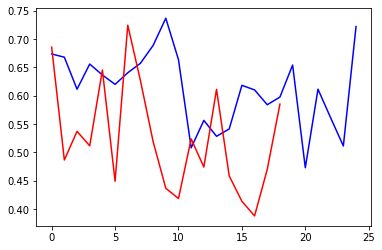

In [ ]:
plt.plot(losses_1, c='b')
plt.plot(losses_2, c='r')

Hard to read say anything from this.


## Conclusion

No pattern has been found, maybe because the models do not have a different enough performance, but they are the two with the furthest performance we have...

# Assignment 5: Sequence labelling

By: Rikke Rhode Nissen

In [ ]:
from transformers import AdamW, AutoModelForQuestionAnswering, get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import LambdaLR
from collections import defaultdict, OrderedDict

In [ ]:
from evaluate import load
squad_metric = load("squad_v2")

## 5.a Convert data to IOB format

In [ ]:
def rename_to_squad(annotations):
  return {'answer_start': annotations['answer_start'], 'text': annotations['answer_text']}

In [ ]:
train_all = get_data(pd.concat([train_en, train_fi, train_ja]), include=['question_text','annotations'])
test_all = get_data(pd.concat([test_en, test_fi, test_ja]), include=['question_text','annotations'])

dict_all = datasets.DatasetDict({'train':train_all, 'test':test_all}).rename_column('__index_level_0__','id')
dict_all = dict_all.map(lambda x: {'answers': rename_to_squad(x['annotations'])}, remove_columns='annotations').rename_columns({'text':'context', 'question_text':'question'})
dict_all

  0%|          | 0/29868 [00:00<?, ?ex/s]

  0%|          | 0/3712 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['context', 'label', 'question', 'id', 'answers'],
        num_rows: 29868
    })
    test: Dataset({
        features: ['context', 'label', 'question', 'id', 'answers'],
        num_rows: 3712
    })
})

In [ ]:
def spans(text):
  # Function to get span for each token

  tokens = text.split()
  offset=0
  pos = []
  for t,token in enumerate(tokens):
    offset = text.find(token, offset)
    pos.append(offset)
    offset += len(token)

  return np.array(pos)

In [ ]:
def IOB_tagging(text, annotations):
  if type(text) is list: text = text[0]
  if type(annotations) is list: annotations = annotations[0]

  # Tokenization of text
  text_tok = text.split()

  # Answer start and length
  answer_start = annotations['answer_start'][0]
  answer_len = len(annotations['answer_text'][0])

  # Fill O, B, I, respectively
  sp = spans(text)
  IOB_tokens = np.repeat('O', len(text_tok))
  IOB_tokens[sp == answer_start] = 'B'
  IOB_tokens[(answer_start < sp) * (sp <= answer_start+answer_len)] = 'I'

  return IOB_tokens

### For each language

In [ ]:
# Define dictionary datasets
train_iob_en = get_data(train_en, include=['question_text','annotations'])
train_iob_fi = get_data(train_fi, include=['question_text','annotations'])
train_iob_ja = get_data(train_ja, include=['question_text','annotations'])

test_iob_en = get_data(test_en, include=['question_text','annotations'])
test_iob_fi = get_data(test_fi, include=['question_text','annotations'])
test_iob_ja = get_data(test_ja, include=['question_text','annotations'])

dict_en = datasets.DatasetDict({'train':train_iob_en, 'test':test_iob_en}).rename_column('__index_level_0__','id')
dict_fi = datasets.DatasetDict({'train':train_iob_fi, 'test':test_iob_fi}).rename_column('__index_level_0__','id')
dict_ja = datasets.DatasetDict({'train':train_iob_ja, 'test':test_iob_ja}).rename_column('__index_level_0__','id')

In [ ]:
iob_en = dict_en.map(lambda x: {"IOB_tags":IOB_tagging(x['text'], x['annotations'])})#,batched=True, num_proc=4, remove_columns=['__index_level_0__'])
iob_fi = dict_fi.map(lambda x: {"IOB_tags":IOB_tagging(x['text'], x['annotations'])})
iob_ja = dict_ja.map(lambda x: {"IOB_tags":IOB_tagging(x['text'], x['annotations'])})

  0%|          | 0/7389 [00:00<?, ?ex/s]

  0%|          | 0/990 [00:00<?, ?ex/s]

  0%|          | 0/13701 [00:00<?, ?ex/s]

  0%|          | 0/1686 [00:00<?, ?ex/s]

  0%|          | 0/8778 [00:00<?, ?ex/s]

  0%|          | 0/1036 [00:00<?, ?ex/s]

In [ ]:
dict_en = dict_en.map(lambda x: {'answers': rename_to_squad(x['annotations'])}, remove_columns='annotations').rename_columns({'text':'context', 'question_text':'question'})
dict_fi = dict_fi.map(lambda x: {'answers': rename_to_squad(x['annotations'])}, remove_columns='annotations').rename_columns({'text':'context', 'question_text':'question'})
dict_ja = dict_ja.map(lambda x: {'answers': rename_to_squad(x['annotations'])}, remove_columns='annotations').rename_columns({'text':'context', 'question_text':'question'})

  0%|          | 0/7389 [00:00<?, ?ex/s]

  0%|          | 0/990 [00:00<?, ?ex/s]

  0%|          | 0/13701 [00:00<?, ?ex/s]

  0%|          | 0/1686 [00:00<?, ?ex/s]

  0%|          | 0/8778 [00:00<?, ?ex/s]

  0%|          | 0/1036 [00:00<?, ?ex/s]

## 5.b+c Implement sequence labeller based on question and paragraph (incl. beam search extension)

In [ ]:
model_name = 'xlm-roberta-base'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForQuestionAnswering: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream tas

In [ ]:
# Preprocessing

max_length = 384
doc_stride = 128

### Functions to encode, train, predict and decode data

In [ ]:
def prepare_train_features(examples):
    '''
    Tokenizes text in a given sample and splitting too long inputs.
    Find token offsets of the answers which serves as a label.
    '''
    # Remove whitespece on the left of question (could potentially take to much space for the truncation)
    examples["question"] = [q.lstrip() for q in examples["question"]]

    tk_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tk_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tk_examples.pop("offset_mapping")

    # Store start and end position of tokens
    tk_examples["start_positions"] = []
    tk_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # Impossible answers will be labelled with the index os the CLS token
        input_ids = tk_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Get the sequence id to combine question and context
        sequence_ids = tk_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tk_examples["start_positions"].append(cls_index)
            tk_examples["end_positions"].append(cls_index)
        else:
            # Get position of start and end character
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers['text'][0])

            # Start from the first token in the context
            start_token_idx = 0
            while sequence_ids[start_token_idx] != 1:
                start_token_idx += 1

            # End token index of the current span in the text.
            end_token_idx = len(offsets) - 1 #
            while sequence_ids[end_token_idx] != 1:
                end_token_idx -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[start_token_idx][0] <= start_char and offsets[end_token_idx][1] >= end_char):
                tk_examples["start_positions"].append(cls_index)
                tk_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the start_token_idx and end_token_idx to the two ends of the answer.
                # Meaning advance the start token index and decreasing the end token index until
                # we have passed the start character index.
                while start_token_idx < len(offsets) and offsets[start_token_idx][0] <= start_char:
                    start_token_idx += 1
                tk_examples["start_positions"].append(start_token_idx - 1)
                while offsets[end_token_idx][1] >= end_char:
                    end_token_idx -= 1
                tk_examples["end_positions"].append(end_token_idx + 1)

    return tk_examples

In [ ]:
def collate_fn(inputs):
  '''
  Defines how to combine different samples in a batch
  '''
  input_ids = torch.tensor([i['input_ids'] for i in inputs])
  attention_mask = torch.tensor([i['attention_mask'] for i in inputs])
  start_positions = torch.tensor([i['start_positions'] for i in inputs])
  end_positions = torch.tensor([i['end_positions'] for i in inputs])

  # Truncate to max length
  max_len = max(attention_mask.sum(-1))
  input_ids = input_ids[:,:max_len]
  attention_mask = attention_mask[:,:max_len]

  return {'input_ids': input_ids, 'attention_mask': attention_mask, 'start_positions': start_positions, 'end_positions': end_positions}

In [ ]:
def train(
    model: nn.Module,
    train_dl: DataLoader,
    optimizer: torch.optim.Optimizer,
    schedule: LambdaLR,
    n_epochs: int,
    device: torch.device
):
  """
  Training loop which optimizes a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  """

  # Track losses and accuracy
  losses = []
  best_acc = 0.0
  pcounter = 0

  # Iterate through epochs
  for epoch in range(n_epochs):

    loss_epoch = []

    # Iterate through batches in dataloader
    for batch in tqdm(train_dl):
      # Ensure model in training mode
      model.train()

      # Clear gradients
      optimizer.zero_grad()

      # Batch on device
      batch = {b: batch[b].to(device) for b in batch}

      # Pass the inputs through the model, get the current loss and logits
      outputs = model(
          input_ids=batch['input_ids'],
          attention_mask=batch['attention_mask'],
          start_positions=batch['start_positions'],
          end_positions=batch['end_positions']
      )
      loss = outputs['loss']
      losses.append(loss.item())
      loss_epoch.append(loss.item())

      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model and advance the LR schedule
      optimizer.step()
      scheduler.step()
  return losses

In [ ]:
def prepare_validation_features(examples):
    # Remove whitespece on the left of question (could potentially take to much space for the truncation)
    examples["question"] = [q.lstrip() for q in examples["question"]]


    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tk_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tk_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tk_examples["example_id"] = []

    for i in range(len(tk_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tk_examples.sequence_ids(i)
        context_index = 1

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tk_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tk_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tk_examples["offset_mapping"][i])
        ]

    return tk_examples


def val_collate_fn(inputs):
  input_ids = torch.tensor([i['input_ids'] for i in inputs])
  attention_mask = torch.tensor([i['attention_mask'] for i in inputs])

  # Truncate to max length
  max_len = max(attention_mask.sum(-1))
  input_ids = input_ids[:,:max_len]
  attention_mask = attention_mask[:,:max_len]

  return {'input_ids': input_ids, 'attention_mask': attention_mask}

In [ ]:
def predict(model: nn.Module, valid_dl: DataLoader):
  """
  Evaluates the model on the given dataset
  :param model: The model under evaluation
  :param valid_dl: A `DataLoader` reading validation data
  :return: The accuracy of the model on the dataset
  """
  # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like
  # layer normalization and dropout
  model.eval()
  start_logits_all = []
  end_logits_all = []

  # ALSO IMPORTANT: Don't accumulate gradients during this process
  with torch.no_grad():
    for batch in tqdm(valid_dl, desc='Evaluation'):
      batch = {b: batch[b].to(device) for b in batch}

      # Pass the inputs through the model, get the current loss and logits
      outputs = model(
          input_ids=batch['input_ids'],
          attention_mask=batch['attention_mask']
      )
      # Store the "start" class logits and "end" class logits for every token in the input
      start_logits_all.extend(list(outputs['start_logits'].detach().cpu().numpy()))
      end_logits_all.extend(list(outputs['end_logits'].detach().cpu().numpy()))


    return start_logits_all,end_logits_all

In [ ]:
def post_process_predictions(examples, dataset, logits, n_best_size = 20, max_answer_length = 30, beam_search=True):
  all_start_logits, all_end_logits = logits

  # Build a map from example to its corresponding features. This will allow us to index from
  # sample ID to all of the features for that sample (in case they were split up due to long input)
  example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
  features_per_example = defaultdict(list)
  for i, feature in enumerate(dataset):
      features_per_example[example_id_to_index[feature["example_id"]]].append(i)

  # Create somewhere to store our predictions
  predictions = OrderedDict()

  # Logging
  print(f"Post-processing {len(examples)} example predictions split into {len(dataset)} features.")

  # Iterate through each sample in the dataset
  for j, example in enumerate(tqdm(examples)):

    # Get the feature indices (all of the features split across the batch)
    feature_indices = features_per_example[j]
    # Get the original context which predumably has the answer text
    text = example['context']

    # Define min_null_score for unanswerable questions
    min_null_score = None
    preds = []

    # Iterate through all of the features
    for ft_idx in feature_indices:

      # Get the start and end answer logits for this input
      start_logits = all_start_logits[ft_idx]
      end_logits = all_end_logits[ft_idx]

      # Get the offsets to map token indices to character indices
      offset_mapping = dataset[ft_idx]['offset_mapping']

      # Update minimum null predictions
      cls_idx = dataset[ft_idx]['input_ids'].index(tokenizer.cls_token_id)
      ft_null_score = start_logits[cls_idx] + end_logits[cls_idx]
      if min_null_score is None or min_null_score < ft_null_score:
        min_null_score = ft_null_score

      # Sort the logits and take the top N
      if beam_search:
        start_indices = np.argsort(start_logits)[::-1][:n_best_size]
      else:
        start_indices = np.argsort(start_logits)[::-1][:1]
      end_indices = np.argsort(end_logits)[::-1][:n_best_size]

      # Iterate through start and end indices
      for start_index in start_indices:
        for end_index in end_indices:

          # Ignore out-of-scope answers
          if (
              start_index >= len(offset_mapping)
              or end_index >= len(offset_mapping)
              or offset_mapping[start_index] is None
              or offset_mapping[end_index] is None
          ):
            continue

          # Ignore too long answers or negative length
          if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue

          start_char = offset_mapping[start_index][0]
          end_char = offset_mapping[end_index][1]
          preds.append({
              'score': start_logits[start_index] + end_logits[end_index],
              'text': text[start_char:end_char]
          })

    if len(preds) > 0:
      # Get the best answer (sorted by score)
      best_answer = sorted(preds, key=lambda x: x['score'], reverse=True)[0]
    else:
      # In case we have non-null predictions
      best_answer = {'score': 0.0, 'text': ""}

    # Pick the final answer as the best one or null (missing)
    answer = best_answer['text'] if best_answer['score'] > min_null_score else ""
    predictions[example['id']] = answer

  return predictions

## 5.d Performance of sequence labeller

In [ ]:
tokenized_dataset = dict_all['train'].map(prepare_train_features, batched=True, remove_columns=dict_all["train"].column_names)

  0%|          | 0/30 [00:00<?, ?ba/s]

### Train sample of model to test greedy vs. beam search

In [ ]:
model.init_weights()

In [ ]:
samples = random.sample(list(range(len(tokenized_dataset))), 4000)
tokenized_dataset = tokenized_dataset.select(samples)
train_dl = DataLoader(tokenized_dataset, collate_fn=collate_fn, shuffle=True, batch_size=4)

In [ ]:
# Create the optimizer
lr=2e-5
n_epochs = 3
weight_decay = 0.01
warmup_steps = 200

no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
      'weight_decay': weight_decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    warmup_steps,
    n_epochs * len(train_dl)
)

In [ ]:
losses = train(
    model,
    train_dl,
    optimizer,
    scheduler,
    n_epochs,
    device
)

100%|██████████| 1000/1000 [05:02<00:00,  3.31it/s]


#### Performance greedy search

The model returns logits for start and end positions. If we require n_best_size=1 we ask only to give us the start and end position with the highest probability (logits), not accounting for a certain combination of start and end positions gives an higher overall score.

In [ ]:
validation_dataset = dict_all['test'].map(prepare_validation_features, batched=True, remove_columns=dict_all['test'].column_names)
val = dict_all['test']

val_dl = DataLoader(validation_dataset, collate_fn=val_collate_fn, batch_size=32)
logits = predict(model, val_dl)

predictions = post_process_predictions(val, validation_dataset, logits, beam_search=False)
formatted_predictions = [{'id': str(k), 'prediction_text': v, 'no_answer_probability': 0.0} for k,v in predictions.items()]
gold = [{'id': str(example['id']), 'answers': example['answers']} for example in val]

  0%|          | 0/4 [00:00<?, ?ba/s]

Evaluation: 100%|██████████| 121/121 [01:22<00:00,  1.47it/s]


Post-processing 3712 example predictions split into 3872 features.


100%|██████████| 3712/3712 [00:06<00:00, 554.57it/s]


In [ ]:
squad_metric.compute(predictions=formatted_predictions, references=gold)

{'exact': 63.658405172413794,
 'f1': 67.86102248355358,
 'total': 3712,
 'HasAns_exact': 63.658405172413794,
 'HasAns_f1': 67.86102248355358,
 'HasAns_total': 3712,
 'best_exact': 63.658405172413794,
 'best_exact_thresh': 0.0,
 'best_f1': 67.86102248355358,
 'best_f1_thresh': 0.0}

#### Performance beam search

In [ ]:
validation_dataset = dict_all['test'].map(prepare_validation_features, batched=True, remove_columns=dict_all['test'].column_names)
val = dict_all['test']

val_dl = DataLoader(validation_dataset, collate_fn=val_collate_fn, batch_size=32)
logits = predict(model, val_dl)

predictions = post_process_predictions(val, validation_dataset, logits)
formatted_predictions = [{'id': str(k), 'prediction_text': v, 'no_answer_probability': 0.0} for k,v in predictions.items()]
gold = [{'id': str(example['id']), 'answers': example['answers']} for example in val]

  0%|          | 0/4 [00:00<?, ?ba/s]

Evaluation: 100%|██████████| 121/121 [01:21<00:00,  1.48it/s]


Post-processing 3712 example predictions split into 3872 features.


100%|██████████| 3712/3712 [00:08<00:00, 446.82it/s]


In [ ]:
squad_metric.compute(predictions=formatted_predictions, references=gold)

{'exact': 64.33189655172414,
 'f1': 68.51160183403154,
 'total': 3712,
 'HasAns_exact': 64.33189655172414,
 'HasAns_f1': 68.51160183403154,
 'HasAns_total': 3712,
 'best_exact': 64.33189655172414,
 'best_exact_thresh': 0.0,
 'best_f1': 68.51160183403154,
 'best_f1_thresh': 0.0}

### Training full model

In [ ]:
model.init_weights()

In [ ]:
train_dl = DataLoader(tokenized_dataset, collate_fn=collate_fn, shuffle=True, batch_size=4)

In [ ]:
# Create the optimizer
lr=2e-5
n_epochs = 3
weight_decay = 0.01
warmup_steps = 200

no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
      'weight_decay': weight_decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    warmup_steps,
    n_epochs * len(train_dl)
)

In [ ]:
losses = train(
    model,
    train_dl,
    optimizer,
    scheduler,
    n_epochs,
    device
)

100%|██████████| 7926/7926 [39:30<00:00,  3.34it/s]


#### Validation of full model

In [ ]:
validation_dataset = dict_all['test'].map(prepare_validation_features, batched=True, remove_columns=dict_all['test'].column_names)
val = dict_all['test']

val_dl = DataLoader(validation_dataset, collate_fn=val_collate_fn, batch_size=32)
logits = predict(model, val_dl)

predictions = post_process_predictions(val, validation_dataset, logits)
formatted_predictions = [{'id': str(k), 'prediction_text': v, 'no_answer_probability': 0.0} for k,v in predictions.items()]
gold = [{'id': str(example['id']), 'answers': example['answers']} for example in val]

  0%|          | 0/4 [00:00<?, ?ba/s]

Evaluation: 100%|██████████| 121/121 [01:21<00:00,  1.48it/s]


Post-processing 3712 example predictions split into 3872 features.


100%|██████████| 3712/3712 [00:08<00:00, 457.48it/s]


In [ ]:
# Before fine-tuning
compute_squad(predictions=formatted_predictions, references=gold)

{'exact_match': 0.16163793103448276, 'f1': 2.6325966726400543}

In [ ]:
# After fine-tuning
compute_squad(predictions=formatted_predictions, references=gold)

{'exact_match': 71.875, 'f1': 75.93417049779659}

In [ ]:
results = squad_metric.compute(predictions=formatted_predictions, references=gold)

In [ ]:
results

{'exact': 71.875,
 'f1': 75.93417049779659,
 'total': 3712,
 'HasAns_exact': 71.875,
 'HasAns_f1': 75.93417049779659,
 'HasAns_total': 3712,
 'best_exact': 71.875,
 'best_exact_thresh': 0.0,
 'best_f1': 75.93417049779659,
 'best_f1_thresh': 0.0}

#### Performance across languages

In [ ]:
# English
validation_dataset = dict_en['test'].map(prepare_validation_features, batched=True, remove_columns=dict_en['test'].column_names)
val = dict_en['test']

val_dl = DataLoader(validation_dataset, collate_fn=val_collate_fn, batch_size=32)
logits = predict(model, val_dl)

predictions = post_process_predictions(val, validation_dataset, logits)
formatted_predictions = [{'id': str(k), 'prediction_text': v, 'no_answer_probability': 0.0} for k,v in predictions.items()]
gold = [{'id': str(example['id']), 'answers': example['answers']} for example in val]

print('Validation: English')
print(squad_metric.compute(predictions=formatted_predictions, references=gold))

  0%|          | 0/1 [00:00<?, ?ba/s]

Evaluation: 100%|██████████| 32/32 [00:21<00:00,  1.47it/s]


Post-processing 990 example predictions split into 1021 features.


100%|██████████| 990/990 [00:03<00:00, 316.06it/s]


Validation: English
{'exact': 70.9090909090909, 'f1': 77.32407542974539, 'total': 990, 'HasAns_exact': 70.9090909090909, 'HasAns_f1': 77.32407542974539, 'HasAns_total': 990, 'best_exact': 70.9090909090909, 'best_exact_thresh': 0.0, 'best_f1': 77.32407542974539, 'best_f1_thresh': 0.0}


In [ ]:
# Finnish
validation_dataset = dict_fi['test'].map(prepare_validation_features, batched=True, remove_columns=dict_fi['test'].column_names)
val = dict_fi['test']

val_dl = DataLoader(validation_dataset, collate_fn=val_collate_fn, batch_size=32)
logits = predict(model, val_dl)

predictions = post_process_predictions(val, validation_dataset, logits)
formatted_predictions = [{'id': str(k), 'prediction_text': v, 'no_answer_probability': 0.0} for k,v in predictions.items()]
gold = [{'id': str(example['id']), 'answers': example['answers']} for example in val]

print('Validation: Finnish')
print(squad_metric.compute(predictions=formatted_predictions, references=gold))

  0%|          | 0/2 [00:00<?, ?ba/s]

Evaluation: 100%|██████████| 55/55 [00:34<00:00,  1.59it/s]


Post-processing 1686 example predictions split into 1736 features.


100%|██████████| 1686/1686 [00:06<00:00, 273.39it/s]


Validation: Finnish
{'exact': 74.85172004744959, 'f1': 79.9348395882006, 'total': 1686, 'HasAns_exact': 74.85172004744959, 'HasAns_f1': 79.9348395882006, 'HasAns_total': 1686, 'best_exact': 74.85172004744959, 'best_exact_thresh': 0.0, 'best_f1': 79.9348395882006, 'best_f1_thresh': 0.0}


In [ ]:
# Japanese
validation_dataset = dict_ja['test'].map(prepare_validation_features, batched=True, remove_columns=dict_ja['test'].column_names)
val = dict_ja['test']

val_dl = DataLoader(validation_dataset, collate_fn=val_collate_fn, batch_size=32)
logits = predict(model, val_dl)

predictions = post_process_predictions(val, validation_dataset, logits)
formatted_predictions = [{'id': str(k), 'prediction_text': v, 'no_answer_probability': 0.0} for k,v in predictions.items()]
gold = [{'id': str(example['id']), 'answers': example['answers']} for example in val]

print('Validation: Japanese')
print(squad_metric.compute(predictions=formatted_predictions, references=gold))

  0%|          | 0/2 [00:00<?, ?ba/s]

Evaluation: 100%|██████████| 35/35 [00:25<00:00,  1.40it/s]


Post-processing 1036 example predictions split into 1115 features.


100%|██████████| 1036/1036 [00:02<00:00, 439.54it/s]


Validation: Japanese
{'exact': 67.95366795366796, 'f1': 68.0952380952381, 'total': 1036, 'HasAns_exact': 67.95366795366796, 'HasAns_f1': 68.0952380952381, 'HasAns_total': 1036, 'best_exact': 67.95366795366796, 'best_exact_thresh': 0.0, 'best_f1': 68.0952380952381, 'best_f1_thresh': 0.0}


## 5.e Qualitative investigation

In [ ]:
examples = 100

for i in range(examples):
  print('Q: ', dict_all['test'][i]['question'], '\nA: ', dict_all['test'][i]['answers']['text'][0])

Q:  What is a way to increase your wound healing speed? 
A:  cleaning and protection from reinjury or infection
Q:  Who founded the Burntisland Shipbuilding Company? 
A:  Brothers Amos and Wilfrid Ayre
Q:  What is the surface area of the human cortex? 
A:  2.3–2.8mm
Q:  When did the case of R (Factortame Ltd) v Secretary of State for Transport  take place? 
A:  December 1988
Q:  When was Quezon City founded? 
A:  1939
Q:  When was the first automated pool cleaner developed? 
A:  1912
Q:  How many units has Agatha Christie sold? 
A:  2 billion
Q:  When was Nájera established? 
A:  923
Q:  When was the Republican People's Party formed in Turkey? 
A:  9 September 1923
Q:  When was the Normandy Campaign? 
A:  6 June 1944
Q:  Who was the last leader of the Mali Empire? 
A:  Mansa Mama Maghan
Q:  What are the official languages of Switzerland? 
A:  German, French, Italian and Romansh
Q:  How long does a cold usually last? 
A:  seven to ten days
Q:  Who was Queen Elizabeth II's father? 
A:  K

In [ ]:
examples = 100

for i in range(examples):
  print('Predicted: ', formatted_predictions[i]['prediction_text'], '\nTrue: ', gold[i]['answers']['text'][0])

Predicted:  cleaning and protection from reinjury or infection 
True:  cleaning and protection from reinjury or infection
Predicted:  Brothers Amos and Wilfrid Ayre 
True:  Brothers Amos and Wilfrid Ayre
Predicted:   
True:  2.3–2.8mm
Predicted:   
True:  December 1988
Predicted:  1939 
True:  1939
Predicted:  1912 
True:  1912
Predicted:  100 million 
True:  2 billion
Predicted:   
True:  923
Predicted:  1919 
True:  9 September 1923
Predicted:  6 June 1944 
True:  6 June 1944
Predicted:   
True:  Mansa Mama Maghan
Predicted:  German, French, Italian and Romansh 
True:  German, French, Italian and Romansh
Predicted:  seven to ten days,[2] but some symptoms may last up to three weeks 
True:  seven to ten days
Predicted:  King Edward VIII 
True:  King George VI
Predicted:  1864 
True:  1864
Predicted:   
True:  contrabass tuba
Predicted:  high-energy, high-speed electron or positron 
True:  high-energy, high-speed electron or positron emitted by the radioactive decay of an atomic nucleu

In [ ]:
start_logits, end_logits = logits[0], logits[1]

In [ ]:
len(start_logits)

3872

# Assignment 6: Multilingual models

In [ ]:
model_name = 'xlm-roberta-base'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_qa = AutoModelForQuestionAnswering.from_pretrained(model_name).to(device)
model_binary = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForQuestionAnswering: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream tas

In [ ]:
model_qa.init_weights()
model_qa = AutoModelForQuestionAnswering.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForQuestionAnswering: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream tas

## 6.a Implement multilingual models

## 6.b Cross-lingual evaluation

### IOB tagging system

In [ ]:
# Prepare and define datasets
train_iob_en = get_data(train_en, include=['question_text','annotations'])
train_iob_fi = get_data(train_fi, include=['question_text','annotations'])
train_iob_ja = get_data(train_ja, include=['question_text','annotations'])

test_iob_en = get_data(test_en, include=['question_text','annotations'])
test_iob_fi = get_data(test_fi, include=['question_text','annotations'])
test_iob_ja = get_data(test_ja, include=['question_text','annotations'])

dict_en = datasets.DatasetDict({'train':train_iob_en, 'test':test_iob_en}).rename_column('__index_level_0__','id')
dict_fi = datasets.DatasetDict({'train':train_iob_fi, 'test':test_iob_fi}).rename_column('__index_level_0__','id')
dict_ja = datasets.DatasetDict({'train':train_iob_ja, 'test':test_iob_ja}).rename_column('__index_level_0__','id')

dict_en = dict_en.map(lambda x: {'answers': rename_to_squad(x['annotations'])}, remove_columns='annotations').rename_columns({'text':'context', 'question_text':'question'})
dict_fi = dict_fi.map(lambda x: {'answers': rename_to_squad(x['annotations'])}, remove_columns='annotations').rename_columns({'text':'context', 'question_text':'question'})
dict_ja = dict_ja.map(lambda x: {'answers': rename_to_squad(x['annotations'])}, remove_columns='annotations').rename_columns({'text':'context', 'question_text':'question'})

  0%|          | 0/7389 [00:00<?, ?ex/s]

  0%|          | 0/990 [00:00<?, ?ex/s]

  0%|          | 0/13701 [00:00<?, ?ex/s]

  0%|          | 0/1686 [00:00<?, ?ex/s]

  0%|          | 0/8778 [00:00<?, ?ex/s]

  0%|          | 0/1036 [00:00<?, ?ex/s]

#### Train english

In [ ]:
tokenized_dataset = dict_en['train'].map(prepare_train_features, batched=True, remove_columns=dict_en["train"].column_names)

  0%|          | 0/8 [00:00<?, ?ba/s]

In [ ]:
samples = random.sample(list(range(len(tokenized_dataset))), 1000)
tokenized_dataset = tokenized_dataset.select(samples)
train_dl = DataLoader(tokenized_dataset, collate_fn=collate_fn, shuffle=True, batch_size=4)

In [ ]:
model_qa.init_weights()
model_qa = AutoModelForQuestionAnswering.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForQuestionAnswering: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream tas

In [ ]:
# Create the optimizer
lr=2e-5
n_epochs = 3
weight_decay = 0.01
warmup_steps = 200

no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model_qa.named_parameters() if not any(nd in n for nd in no_decay)],
      'weight_decay': weight_decay},
    {'params': [p for n, p in model_qa.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    warmup_steps,
    n_epochs * len(train_dl)
)

In [ ]:
losses = train(
    model_qa,
    train_dl,
    optimizer,
    scheduler,
    n_epochs,
    device
)

100%|██████████| 250/250 [01:14<00:00,  3.33it/s]


In [ ]:
# Finnish
validation_dataset = dict_fi['test'].map(prepare_validation_features, batched=True, remove_columns=dict_fi['test'].column_names)
val = dict_fi['test']

val_dl = DataLoader(validation_dataset, collate_fn=val_collate_fn, batch_size=32)
logits = predict(model_qa, val_dl)

predictions = post_process_predictions(val, validation_dataset, logits)
formatted_predictions = [{'id': str(k), 'prediction_text': v, 'no_answer_probability': 0.0} for k,v in predictions.items()]
gold = [{'id': str(example['id']), 'answers': example['answers']} for example in val]

print('Validation: Finnish')
print(squad_metric.compute(predictions=formatted_predictions, references=gold))

  0%|          | 0/2 [00:00<?, ?ba/s]

Evaluation: 100%|██████████| 55/55 [00:34<00:00,  1.60it/s]


Post-processing 1686 example predictions split into 1736 features.


100%|██████████| 1686/1686 [00:05<00:00, 312.35it/s]


Validation: Finnish
{'exact': 51.95729537366548, 'f1': 56.79336564025258, 'total': 1686, 'HasAns_exact': 51.95729537366548, 'HasAns_f1': 56.79336564025258, 'HasAns_total': 1686, 'best_exact': 51.95729537366548, 'best_exact_thresh': 0.0, 'best_f1': 56.79336564025258, 'best_f1_thresh': 0.0}


In [ ]:
# Japanese
validation_dataset = dict_ja['test'].map(prepare_validation_features, batched=True, remove_columns=dict_ja['test'].column_names)
val = dict_ja['test']

val_dl = DataLoader(validation_dataset, collate_fn=val_collate_fn, batch_size=32)
logits = predict(model_qa, val_dl)

predictions = post_process_predictions(val, validation_dataset, logits)
formatted_predictions = [{'id': str(k), 'prediction_text': v, 'no_answer_probability': 0.0} for k,v in predictions.items()]
gold = [{'id': str(example['id']), 'answers': example['answers']} for example in val]

print('Validation: Japanese')
print(squad_metric.compute(predictions=formatted_predictions, references=gold))

  0%|          | 0/2 [00:00<?, ?ba/s]

Evaluation: 100%|██████████| 35/35 [00:24<00:00,  1.42it/s]


Post-processing 1036 example predictions split into 1115 features.


100%|██████████| 1036/1036 [00:02<00:00, 442.60it/s]


Validation: Japanese
{'exact': 52.12355212355212, 'f1': 52.25225225225225, 'total': 1036, 'HasAns_exact': 52.12355212355212, 'HasAns_f1': 52.25225225225225, 'HasAns_total': 1036, 'best_exact': 52.12355212355212, 'best_exact_thresh': 0.0, 'best_f1': 52.25225225225225, 'best_f1_thresh': 0.0}


#### Train finnish

In [ ]:
tokenized_dataset = dict_fi['train'].map(prepare_train_features, batched=True, remove_columns=dict_fi["train"].column_names)

  0%|          | 0/14 [00:00<?, ?ba/s]

In [ ]:
samples = random.sample(list(range(len(tokenized_dataset))), 1000)
tokenized_dataset = tokenized_dataset.select(samples)
train_dl = DataLoader(tokenized_dataset, collate_fn=collate_fn, shuffle=True, batch_size=4)

In [ ]:
model_qa.init_weights()
model_qa = AutoModelForQuestionAnswering.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForQuestionAnswering: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream tas

In [ ]:
# Create the optimizer
lr=2e-5
n_epochs = 3
weight_decay = 0.01
warmup_steps = 200

no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model_qa.named_parameters() if not any(nd in n for nd in no_decay)],
      'weight_decay': weight_decay},
    {'params': [p for n, p in model_qa.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    warmup_steps,
    n_epochs * len(train_dl)
)

In [ ]:
losses = train(
    model_qa,
    train_dl,
    optimizer,
    scheduler,
    n_epochs,
    device
)

100%|██████████| 250/250 [01:07<00:00,  3.70it/s]


In [ ]:
# English
validation_dataset = dict_en['test'].map(prepare_validation_features, batched=True, remove_columns=dict_en['test'].column_names)
val = dict_en['test']

val_dl = DataLoader(validation_dataset, collate_fn=val_collate_fn, batch_size=32)
logits = predict(model_qa, val_dl)

predictions = post_process_predictions(val, validation_dataset, logits)
formatted_predictions = [{'id': str(k), 'prediction_text': v, 'no_answer_probability': 0.0} for k,v in predictions.items()]
gold = [{'id': str(example['id']), 'answers': example['answers']} for example in val]

print('Validation: English')
print(squad_metric.compute(predictions=formatted_predictions, references=gold))

  0%|          | 0/1 [00:00<?, ?ba/s]

Evaluation: 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


Post-processing 990 example predictions split into 1021 features.


100%|██████████| 990/990 [00:02<00:00, 440.60it/s]


Validation: English
{'exact': 52.82828282828283, 'f1': 58.967512078100825, 'total': 990, 'HasAns_exact': 52.82828282828283, 'HasAns_f1': 58.967512078100825, 'HasAns_total': 990, 'best_exact': 52.82828282828283, 'best_exact_thresh': 0.0, 'best_f1': 58.967512078100825, 'best_f1_thresh': 0.0}


In [ ]:
# Japanese
validation_dataset = dict_ja['test'].map(prepare_validation_features, batched=True, remove_columns=dict_ja['test'].column_names)
val = dict_ja['test']

val_dl = DataLoader(validation_dataset, collate_fn=val_collate_fn, batch_size=32)
logits = predict(model_qa, val_dl)

predictions = post_process_predictions(val, validation_dataset, logits)
formatted_predictions = [{'id': str(k), 'prediction_text': v, 'no_answer_probability': 0.0} for k,v in predictions.items()]
gold = [{'id': str(example['id']), 'answers': example['answers']} for example in val]

print('Validation: Japanese')
print(squad_metric.compute(predictions=formatted_predictions, references=gold))

  0%|          | 0/2 [00:00<?, ?ba/s]

Evaluation: 100%|██████████| 35/35 [00:24<00:00,  1.42it/s]


Post-processing 1036 example predictions split into 1115 features.


100%|██████████| 1036/1036 [00:02<00:00, 441.82it/s]


Validation: Japanese
{'exact': 54.343629343629345, 'f1': 54.60102960102961, 'total': 1036, 'HasAns_exact': 54.343629343629345, 'HasAns_f1': 54.60102960102961, 'HasAns_total': 1036, 'best_exact': 54.343629343629345, 'best_exact_thresh': 0.0, 'best_f1': 54.60102960102961, 'best_f1_thresh': 0.0}


#### Train japanese

In [ ]:
tokenized_dataset = dict_ja['train'].map(prepare_train_features, batched=True, remove_columns=dict_ja["train"].column_names)

  0%|          | 0/9 [00:00<?, ?ba/s]

In [ ]:
samples = random.sample(list(range(len(tokenized_dataset))), 1000)
tokenized_dataset = tokenized_dataset.select(samples)
train_dl = DataLoader(tokenized_dataset, collate_fn=collate_fn, shuffle=True, batch_size=4)

In [ ]:
model_qa.init_weights()
model_qa = AutoModelForQuestionAnswering.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForQuestionAnswering: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream tas

In [ ]:
# Create the optimizer
lr=2e-5
n_epochs = 3
weight_decay = 0.01
warmup_steps = 200

no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model_qa.named_parameters() if not any(nd in n for nd in no_decay)],
      'weight_decay': weight_decay},
    {'params': [p for n, p in model_qa.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    warmup_steps,
    n_epochs * len(train_dl)
)

In [ ]:
losses = train(
    model_qa,
    train_dl,
    optimizer,
    scheduler,
    n_epochs,
    device
)

100%|██████████| 250/250 [01:21<00:00,  3.08it/s]


In [ ]:
# Finnish
validation_dataset = dict_fi['test'].map(prepare_validation_features, batched=True, remove_columns=dict_fi['test'].column_names)
val = dict_fi['test']

val_dl = DataLoader(validation_dataset, collate_fn=val_collate_fn, batch_size=32)
logits = predict(model_qa, val_dl)

predictions = post_process_predictions(val, validation_dataset, logits)
formatted_predictions = [{'id': str(k), 'prediction_text': v, 'no_answer_probability': 0.0} for k,v in predictions.items()]
gold = [{'id': str(example['id']), 'answers': example['answers']} for example in val]

print('Validation: Finnish')
print(squad_metric.compute(predictions=formatted_predictions, references=gold))

  0%|          | 0/2 [00:00<?, ?ba/s]

Evaluation: 100%|██████████| 55/55 [00:34<00:00,  1.61it/s]


Post-processing 1686 example predictions split into 1736 features.


100%|██████████| 1686/1686 [00:03<00:00, 467.36it/s]


Validation: Finnish
{'exact': 49.05100830367734, 'f1': 51.73209416487265, 'total': 1686, 'HasAns_exact': 49.05100830367734, 'HasAns_f1': 51.73209416487265, 'HasAns_total': 1686, 'best_exact': 49.05100830367734, 'best_exact_thresh': 0.0, 'best_f1': 51.73209416487265, 'best_f1_thresh': 0.0}


In [ ]:
# English
validation_dataset = dict_en['test'].map(prepare_validation_features, batched=True, remove_columns=dict_en['test'].column_names)
val = dict_en['test']

val_dl = DataLoader(validation_dataset, collate_fn=val_collate_fn, batch_size=32)
logits = predict(model_qa, val_dl)

predictions = post_process_predictions(val, validation_dataset, logits)
formatted_predictions = [{'id': str(k), 'prediction_text': v, 'no_answer_probability': 0.0} for k,v in predictions.items()]
gold = [{'id': str(example['id']), 'answers': example['answers']} for example in val]

print('Validation: English')
print(squad_metric.compute(predictions=formatted_predictions, references=gold))

  0%|          | 0/1 [00:00<?, ?ba/s]

Evaluation: 100%|██████████| 32/32 [00:22<00:00,  1.44it/s]


Post-processing 990 example predictions split into 1021 features.


100%|██████████| 990/990 [00:02<00:00, 465.35it/s]


Validation: English
{'exact': 50.707070707070706, 'f1': 52.28084054372719, 'total': 990, 'HasAns_exact': 50.707070707070706, 'HasAns_f1': 52.28084054372719, 'HasAns_total': 990, 'best_exact': 50.707070707070706, 'best_exact_thresh': 0.0, 'best_f1': 52.28084054372719, 'best_f1_thresh': 0.0}


## 6.c Comparing the performances

Let's compare the models for the tasks of binary classification (answerable and not-answerable) and the task of span-based QA.

In [ ]:
def compare_results(results:dict, by='language', language='English', metric='accuracy'):
  by_language = True if by == 'language' else False
  sorted_dic = {k: v for k, v in sorted(results.items(), key=lambda item: item[1], reverse=True)}
  if by_language:
    print(f"Rank comparing {metric}")
    for i, key in enumerate(sorted_dic):
      print(f"{i+1}. {key}: {sorted_dic[key]}")
  else:
    print(f"Rank of tasks for {language}")
    for i, key in enumerate(sorted_dic):
      print(f"{i+1}. {key}")

### Binary Classification
We use the features that has proven to perform better, that is to say the ones defined in section 2.a, and compare the accuracy.

In [ ]:
dict_BC_lang = {
    "English":0.7394,
    "Finnish":0.7782,
    "Japanese":0.7413
}
compare_results(dict_BC_lang, by='language', metric='accuracy')

Rank comparing accuracy
1. Finnish: 0.7782
2. Japanese: 0.7413
3. English: 0.7394


### Span-based QA
We use the f1 score to compare

In [ ]:
dict_SPQA_lang = {
    "English": 77.324,
    "Finnish": 79.935,
    "Japanese": 68.095
}
compare_results(dict_SPQA_lang, metric='f1 score')

Rank comparing f1 score
1. Finnish: 79.935
2. English: 77.324
3. Japanese: 68.095


### Conclusion
We can see that both the tasks achieve the best performance in Finnish, whereas in Japanese, even though the classifier has a performance close to Finnish, the sequence labeller does not perform very well, with a f1 score almost 10 points under the one in Finnish. \\
Regarding the English language, both tasks achieve good performances.